https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

### тут же ищем параметры для power law

находим параметры повер лау для шагов разной длительности. также смотрим, как отличаются параметры возле стен, в углах, в центре поля

In [2]:
import statistics
from scipy.optimize import curve_fit
# from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [3]:
def power_law(x, a, b):
    return a*x**b

def powerlaw_with_bias(x, m, c, c0):
    return c0 + x**m * c

In [5]:
def build3ShistLog(df,n):
    #sampRate = len(df) / (df.iloc[-1]['time'] - df.iloc[0]['time'])
    #step = round(sampRate * n)
    #chose which samples will remain
    df = df.dropna()
    df = df.reset_index()
    df = df.drop(['index'], axis=1)

    # TODO: is it resampling??? if yes - remove 
    time_last = df['time'][0]
    ind_good = [0]
    for i in range(1, len(df)):
        if df['time'][i] - time_last >= n:
            time_last = df['time'][i]
            ind_good.append(i)    
    df = df.iloc[ind_good]
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    
    #k = []
    #if step == 0:
        #step = 1
    #for i in range(len(df)):
        #if i % step == 0:
            #k.append(i)
    #df = df.iloc[k]
    
    xy = []
    x0 = df['x'][0]
    y0 = df['y'][0]
    #delX = []
    #delY = []
    for i in range(len(df)):
        # TODO: why this formula?
        
        dx = df.iloc[i]['x'] - x0
        dy = df.iloc[i]['y'] - y0
        xxy = pow(pow(dx, 2) + pow(dy, 2), 0.5)
        #delX.append(dx)
        #delY.append(dy)
        xy.append(xxy)
        x0 = df.iloc[i]['x']
        y0 = df.iloc[i]['y']

    df.insert(3, "xy", xy)

    xynum = df['xy'].to_numpy()
    #histogram
    plt.figure()
    plt.yscale("log")
    kk = plt.hist(xynum, bins=100)
    plt.show()
    return kk

def makeRegrNew(histOut, trn):
    x = histOut[1][1:]
    y = histOut[0]
    # Fit the dummy power-law data
    pars, cov = curve_fit(f=power_law, xdata=x, ydata=y, p0=[0, 0], bounds=(-np.inf, np.inf))
    # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    # Calculate the residuals
    res = y - power_law(x, *pars)
    print(pars)
    return pars   

### Load Trajectories (or preproc)

In [6]:
def open_preprocessed_data(fname):
    import pickle
    with open(fname, 'rb') as inp:
        sub_trajs_list = pickle.load(inp)
    return sub_trajs_list

# Open pre-processed files (or use preproc functions for raw data)
PATH = 'preprocessed_dataset/'
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']


df_dict_subtraj = {}
for tr_name in dfs_names:
    tr = open_preprocessed_data(PATH + tr_name + '.pkl')
    df_dict_subtraj[tr_name] = tr

df_dict = {}
for k, df in df_dict_subtraj.items():
    df_dict[k] = pd.concat(df)

## If raw dataset:
# 1. cut_jumps;
# 2. rescale x and y coords to fit area size 
# 3. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
# 4. resample to required dt

In [129]:
def build_log_hist(df, binn, hist_title):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx.iloc[0], dy.iloc[0] = 0., 0.

    ## Ignore gaps in recording (== 0.)
    mask = dx.index != 0
    dx = dx * 1*mask
    dy = dy * 1*mask    

    xy = (dx**2 + dy**2)**0.5
    df['xy'] = xy 

    plt.yscale("log")
    xy_np = df['xy'].to_numpy()
    kk = plt.hist(xy_np, bins=binn)
    plt.title(f'{hist_title}, samples num: {df.shape[0]}')
    plt.show()

    return kk

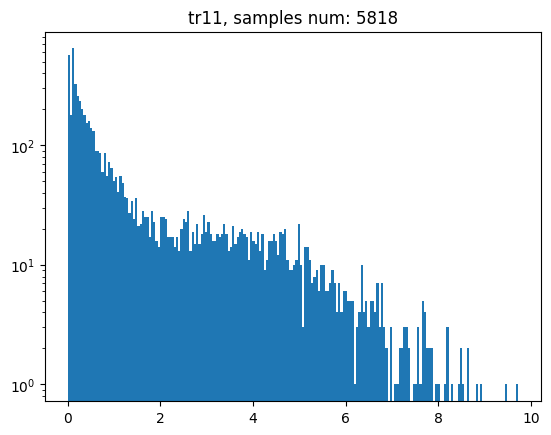

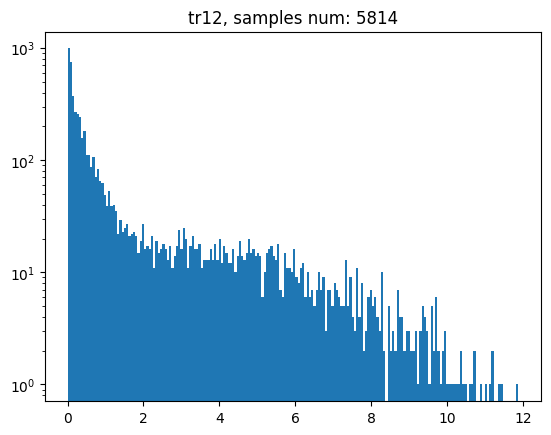

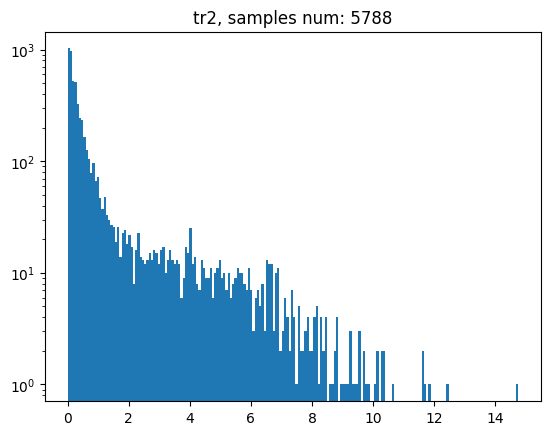

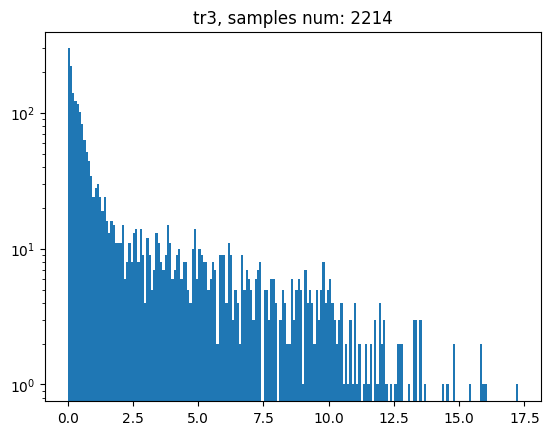

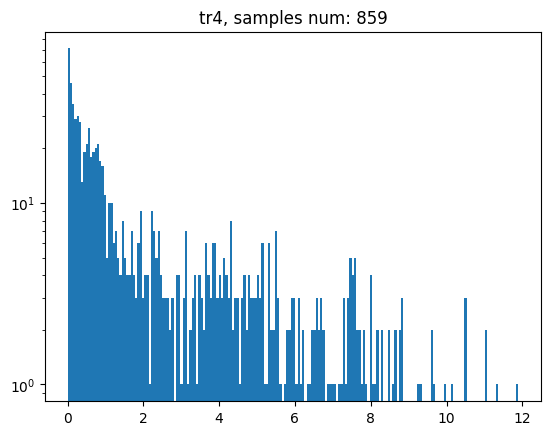

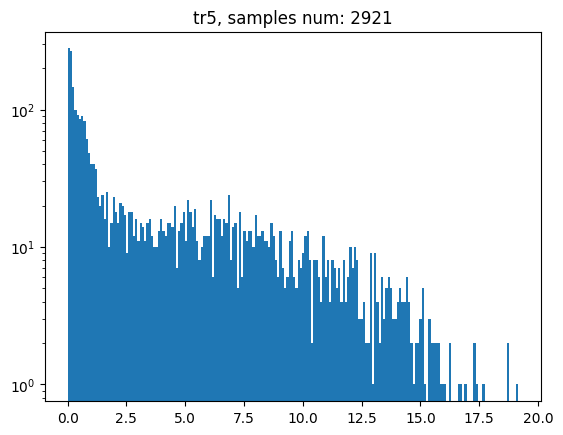

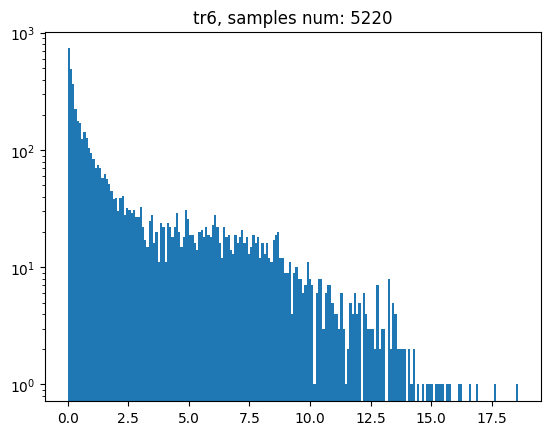

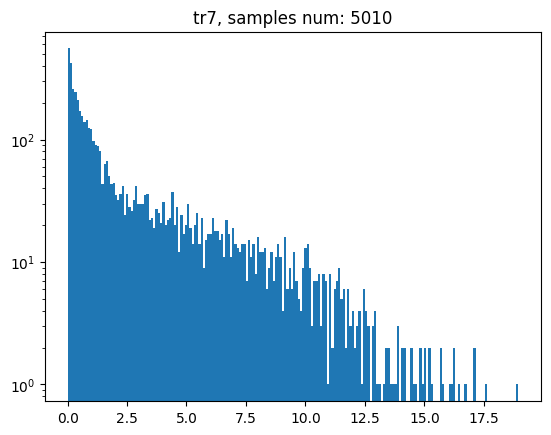

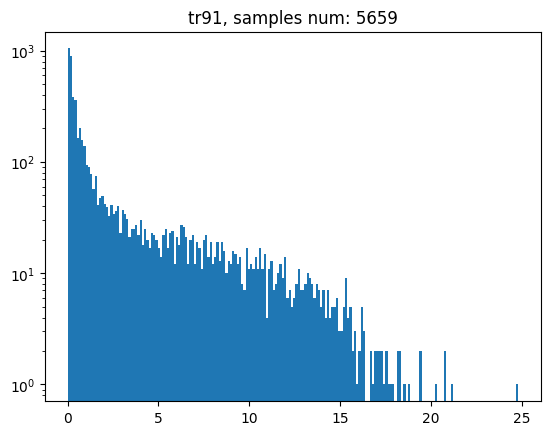

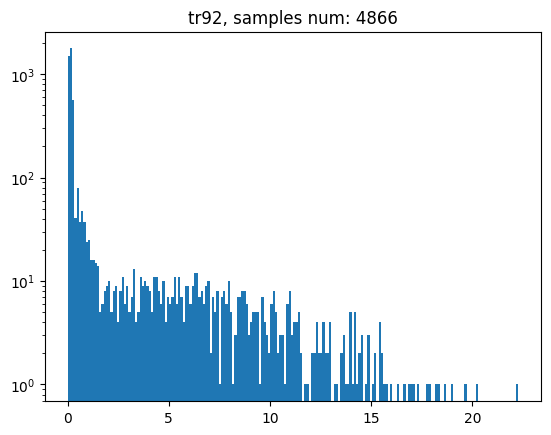

In [130]:
df_steps_hist = {}
for k, df in df_dict.items():

    h = build_log_hist(df, binn=200, hist_title=k)
    df_steps_hist[k] = h
    # TODO: what is the name of x-axis ??? len of area len units ???
    # TODO: threshold for dropping "sitting" column

## Fit power law and power law with bias and check the quality of fit

In [66]:
def power_law(x, m, c):
    return c * x**m

def powerlaw_with_bias(x, m, c, c0):
    return c * x**m + c0

for tr11:


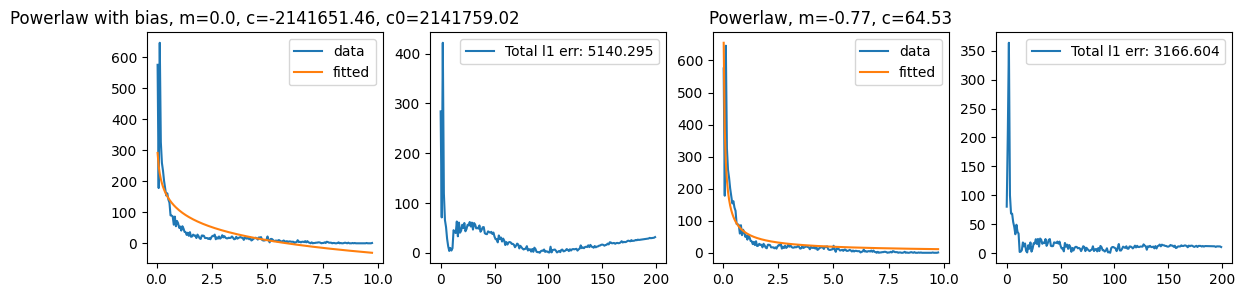

for tr12:


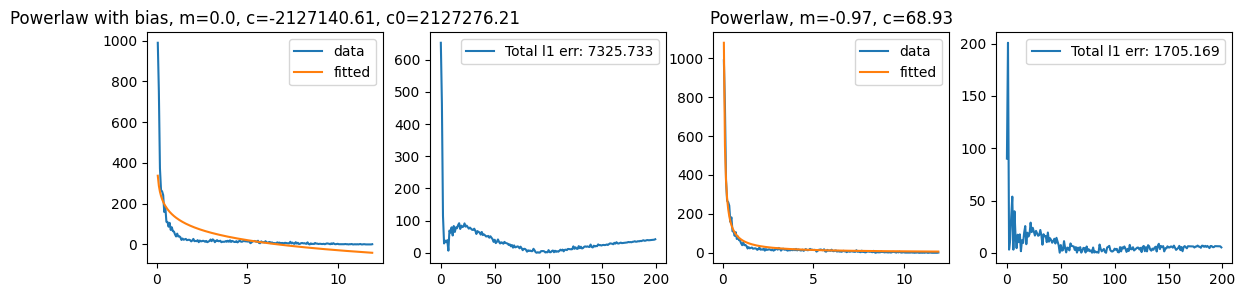

for tr2:


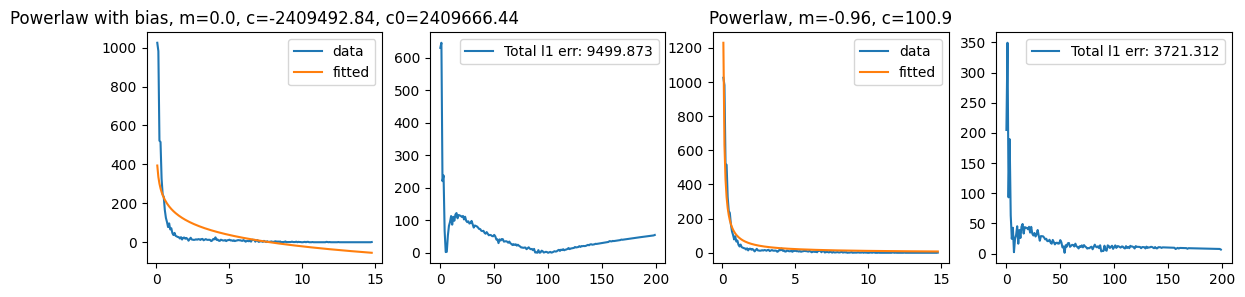

for tr3:


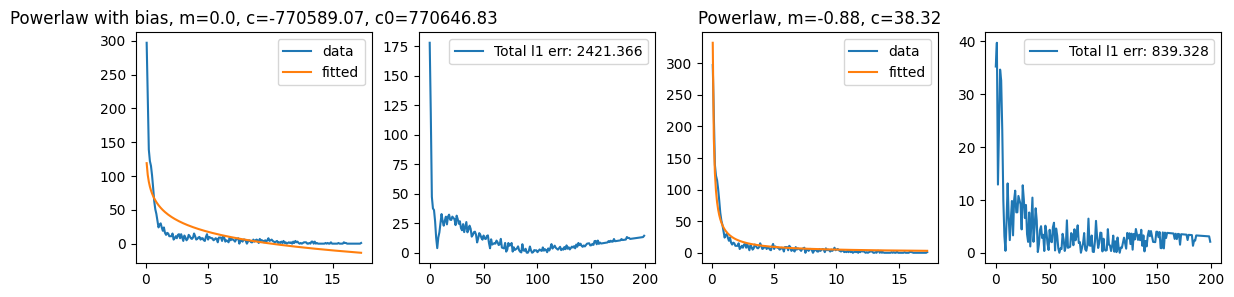

for tr4:


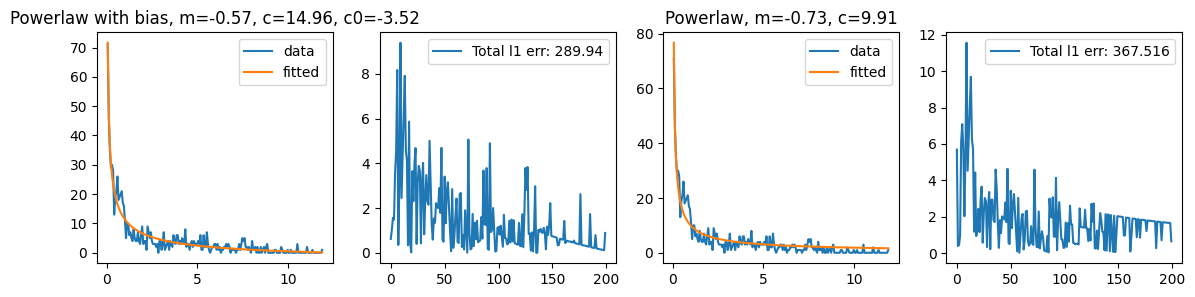

for tr5:


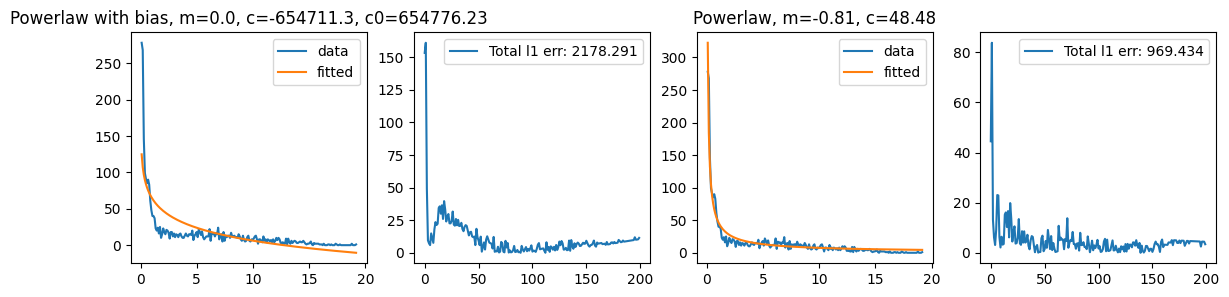

for tr6:


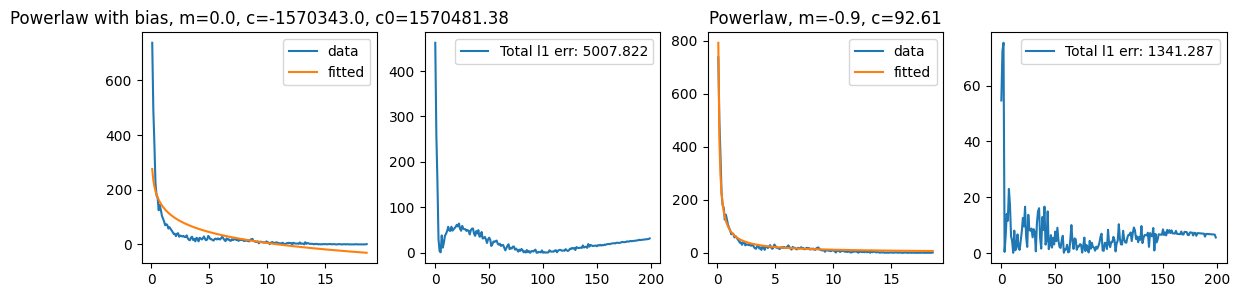

for tr7:


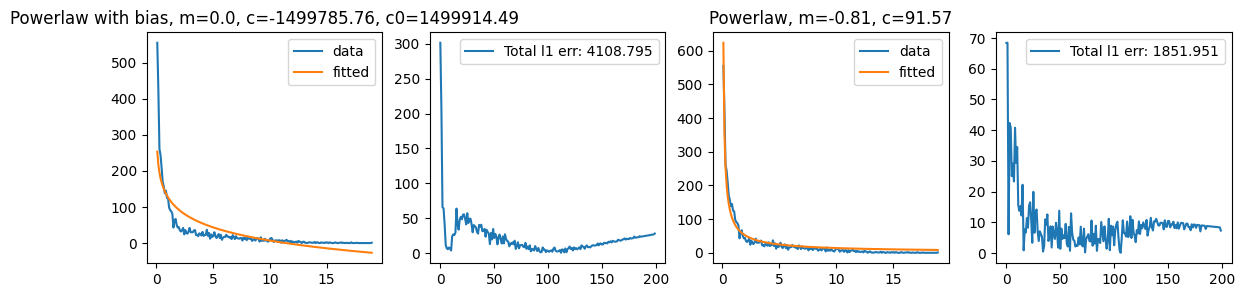

for tr91:


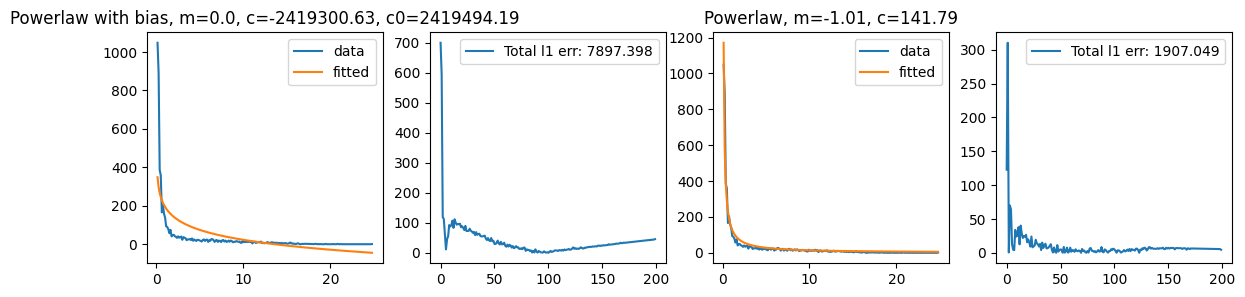

for tr92:


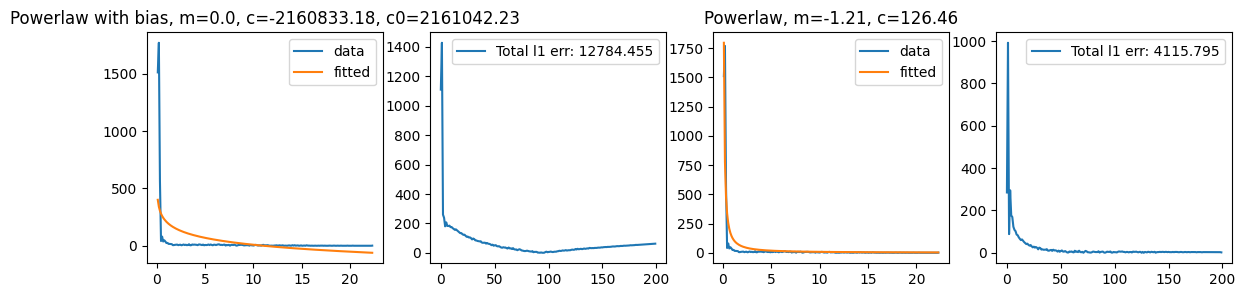

In [81]:
def powerlaw_with_bias_(x, params):
    m, c, c0 = params
    return c * x**m + c0

def power_law_(x, params):
    m, c = params
    return c * x**m


for k, df in df_steps_hist.items():
    x = df[1][1:]  # vals
    y = df[0]  # freqs
    print(f'for {k}:')

    sol1 = curve_fit(power_law, x, y, p0 = np.asarray([1., 10**5]))
    sol2 = curve_fit(powerlaw_with_bias, x, y, 
                    p0 = np.asarray([1., 10**3, 0.]), maxfev = 2000)
    
    params = sol2[0]
    qq = powerlaw_with_bias_(x, params)
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))
    ax[0].plot(x, y, label='data')
    ax[0].plot(x, qq, label='fitted')
    ax[0].set_title(f'Powerlaw with bias, m={round(params[0], 2)}, c={round(params[1], 2)}, c0={round(params[2], 2)}')
    ax[0].legend()
    # residuals
    res = np.abs(y - qq)
    ax[1].plot(res, label=f'Total l1 err: {round(np.sum(res), 3)}')
    ax[1].legend()

    params = sol1[0]
    qq = power_law_(x, params)
    ax[2].plot(x, y, label='data')
    ax[2].plot(x, qq, label='fitted')
    ax[2].set_title(f'Powerlaw, m={round(params[0], 2)}, c={round(params[1], 2)}')
    ax[2].legend()
    # residuals
    res = np.abs(y - qq)
    ax[3].plot(res, label=f'Total l1 err: {round(np.sum(res), 3)}')
    ax[3].legend()

    plt.show()

    # break

In [ ]:
# Make conclusion that power law without bias is better according to residuals

## проведем анализ 0.5 с центр

In [28]:
#удалим тр 92  # TODO: why? maybe just cut 
# del dfs[6]

In [111]:
def sort_walls_area(tr, wall_percent=0.1): 
    ylen = tr['y'].max() - tr['y'].min() 
    xlen = tr['x'].max() - tr['x'].min() 
    xl = tr['x'].min() + xlen * wall_percent
    xr = tr['x'].max() - xlen * wall_percent
    yd = tr['y'].min() + ylen * wall_percent
    yu = tr['y'].max()  - ylen * wall_percent

    near_wall_list = np.zeros((len(tr),))
    for i in range(len(tr)):     
        if tr['x'].iloc[i] < xl:
            if tr['y'].iloc[i] > yu:
                near_wall_list[i] = 40
            elif tr['y'].iloc[i] < yd:
                near_wall_list[i] = 30
            else:
                near_wall_list[i] = 4
        elif tr['x'].iloc[i] > xr:
            if tr['y'].iloc[i] > yu:
                near_wall_list[i] = 10
            elif tr['y'].iloc[i] < yd:
                near_wall_list[i] = 20
            else:
                near_wall_list[i] = 2
        elif tr['y'].iloc[i] > yu:
            near_wall_list[i] = 1
        elif tr['y'].iloc[i] < yd:
            near_wall_list[i] = 3

    tr['near_wall'] = np.asarray(near_wall_list)
    return tr

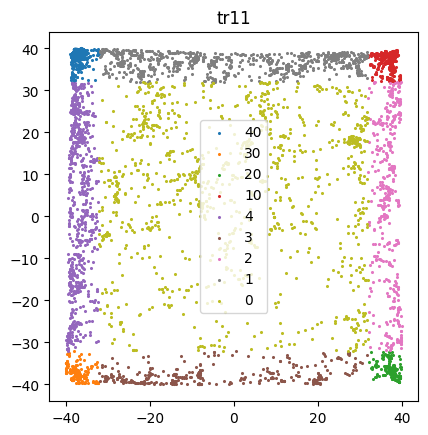

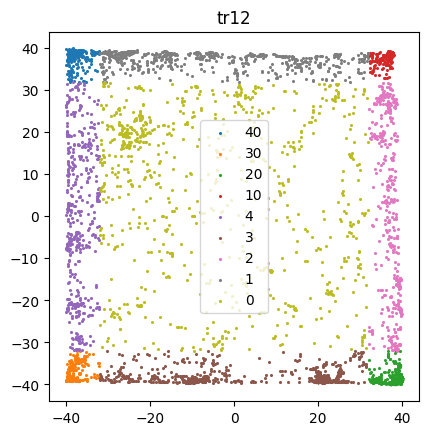

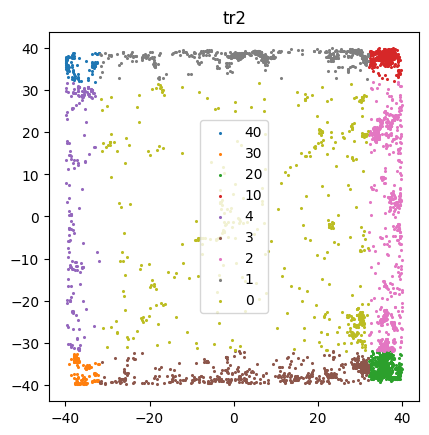

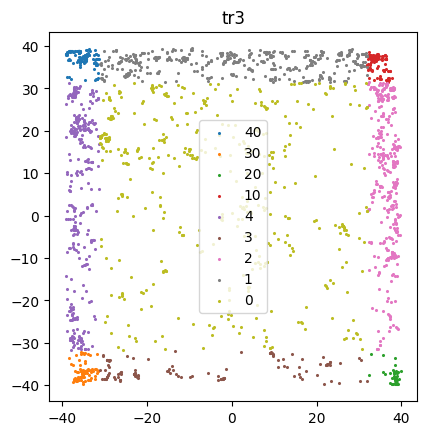

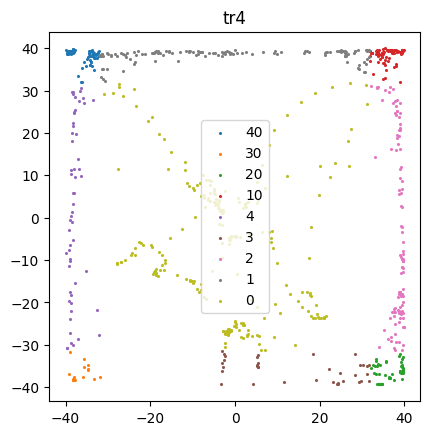

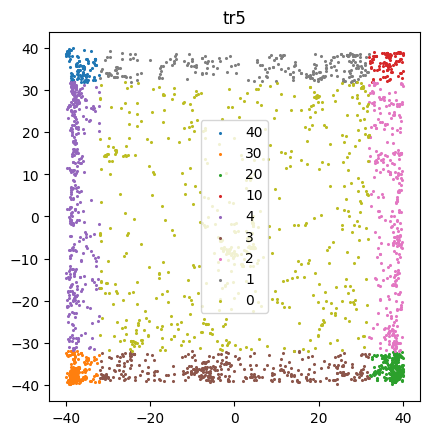

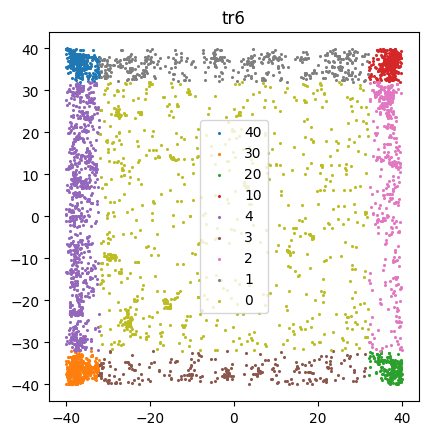

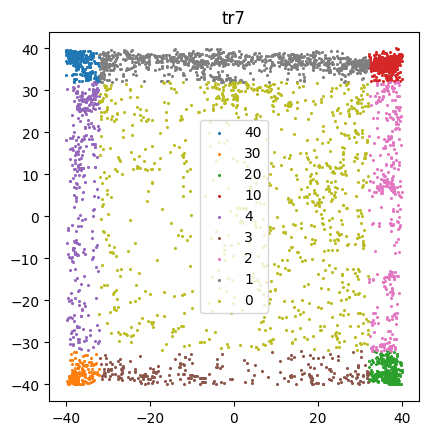

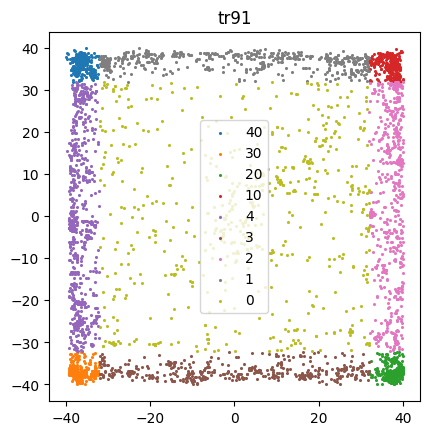

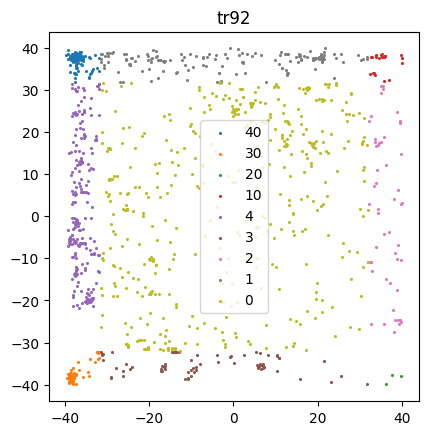

In [112]:
def plot_wall_sorted_samples(df, plot_title):
    all_areas = [40, 30, 20, 10, 4, 3, 2, 1, 0]
    for a in all_areas:
        x = df.loc[df['near_wall'] == a]['x']
        y = df.loc[df['near_wall'] == a]['y']
        plt.scatter(x, y, s=1.5, label=str(a))
    plt.gca().set_aspect('equal')
    plt.title(plot_title)
    plt.legend(loc='center')
    plt.show()


df_dict_areas = {}
for k, df in df_dict.items():
    df_areas = sort_walls_area(df, wall_percent=0.1)
    df_dict_areas[k] = df_areas
    plot_wall_sorted_samples(df_areas, k)

tr11 0.0


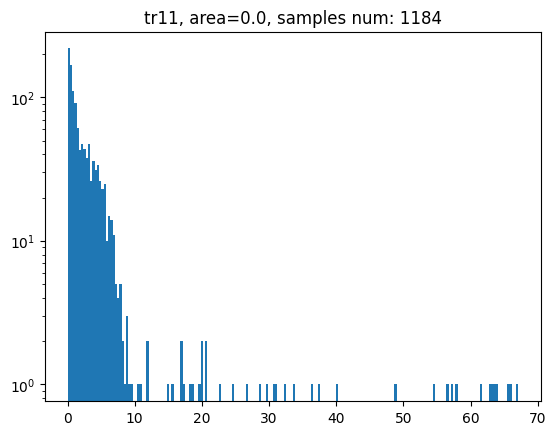

tr11 1.0


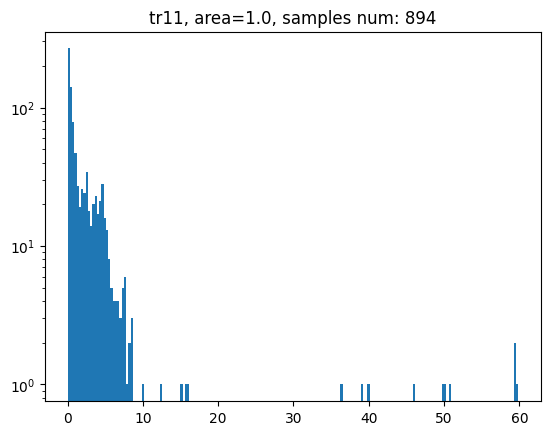

tr11 2.0


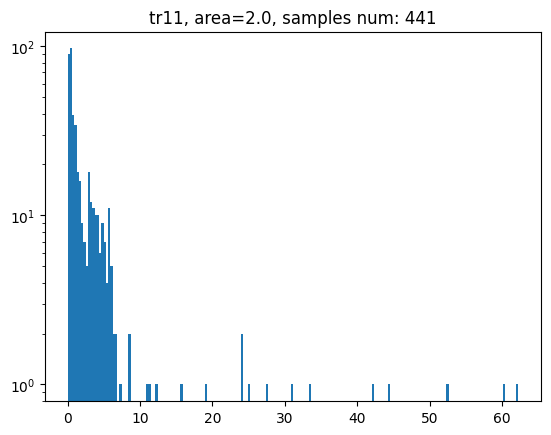

tr11 3.0


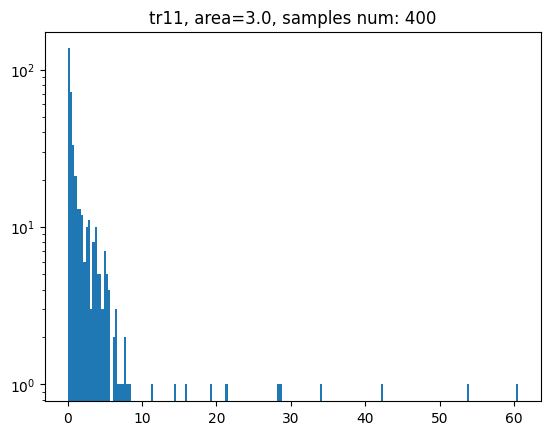

tr11 4.0


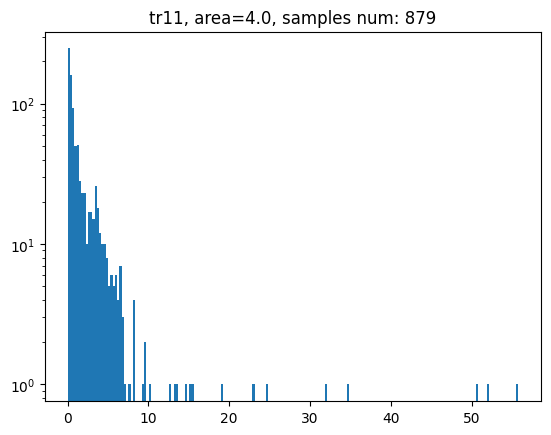

tr11 10.0


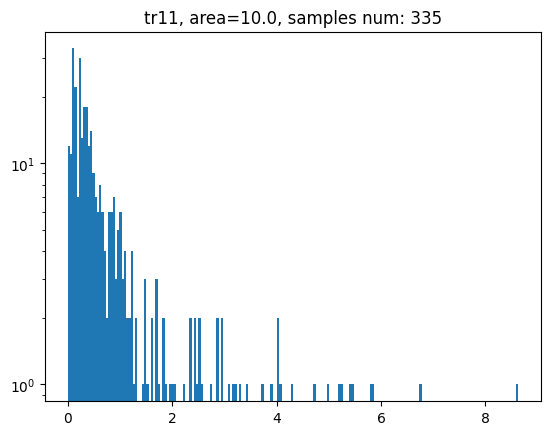

tr11 20.0


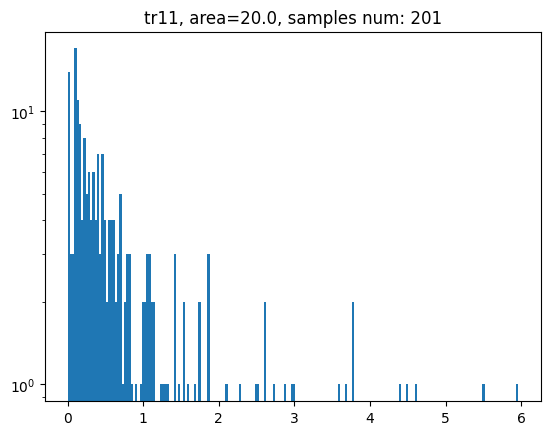

tr11 30.0


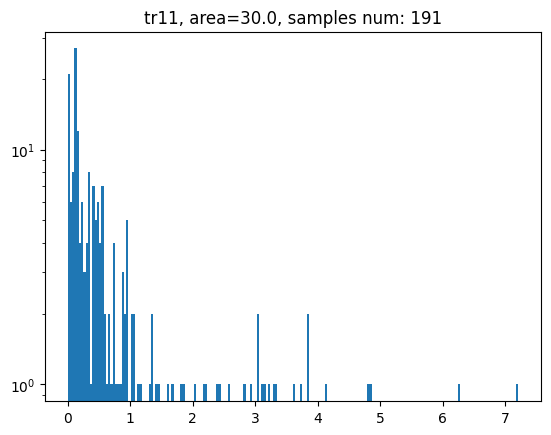

tr11 40


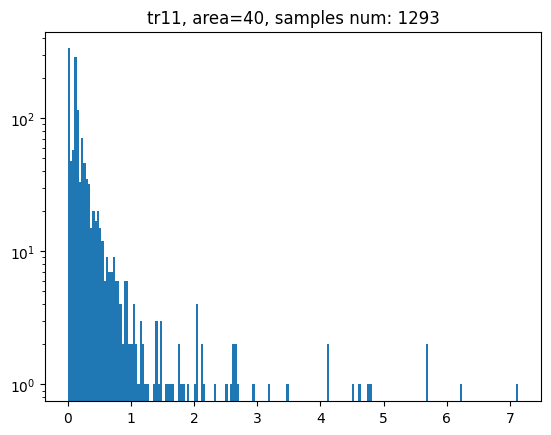

tr12 0.0


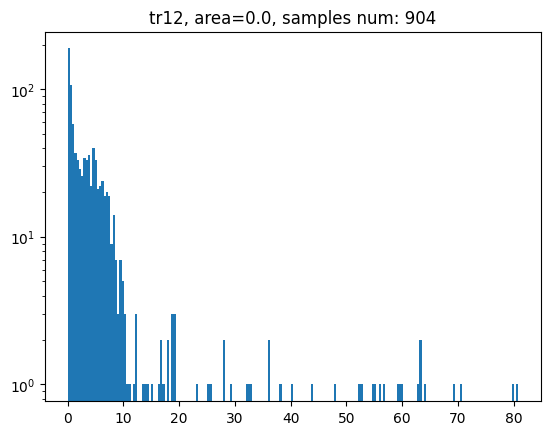

tr12 1.0


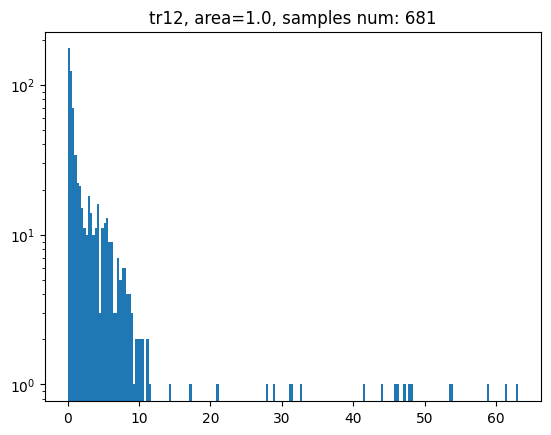

tr12 2.0


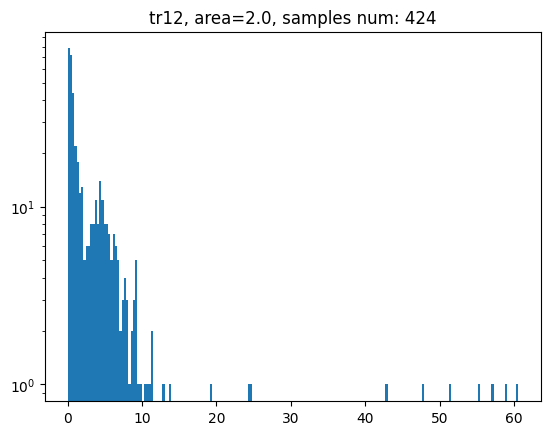

tr12 3.0


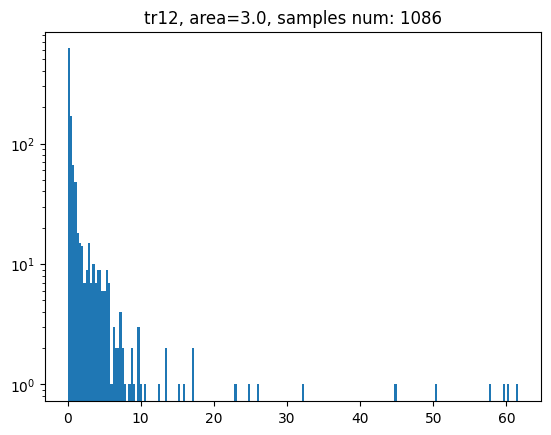

tr12 4.0


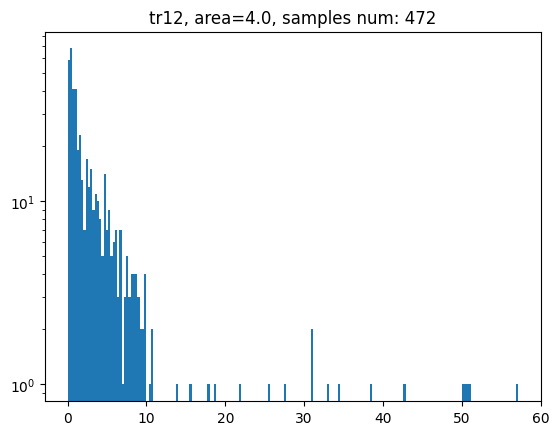

tr12 10.0


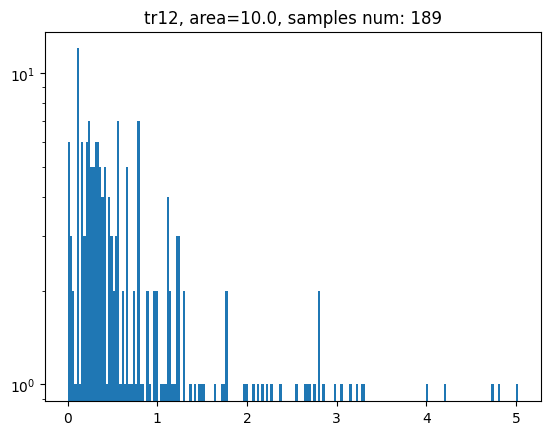

tr12 20.0


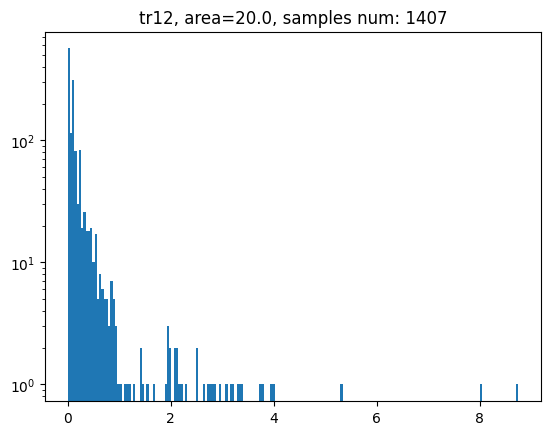

tr12 30.0


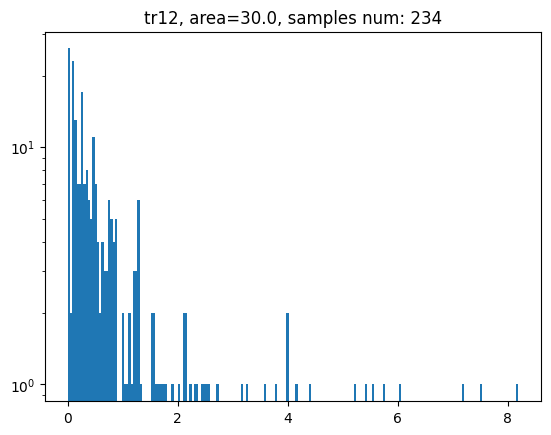

tr12 40


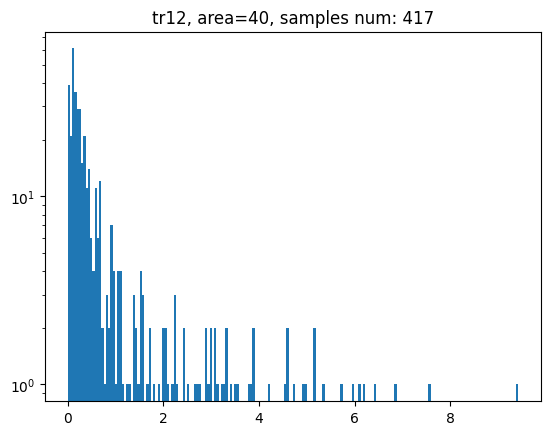

tr2 0.0


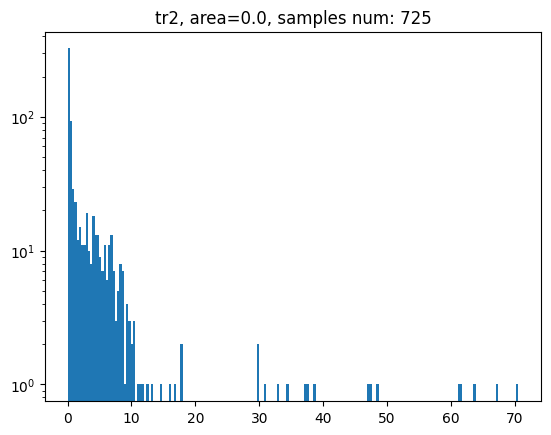

tr2 1.0


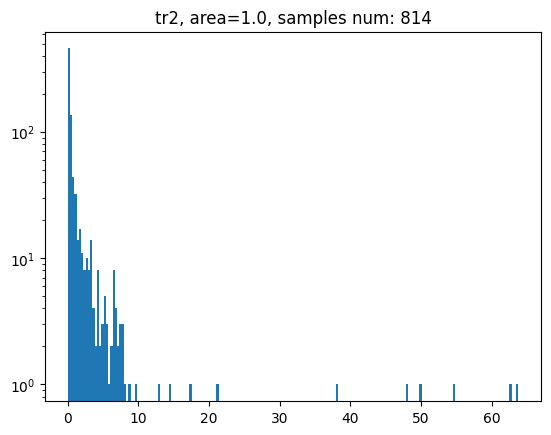

tr2 2.0


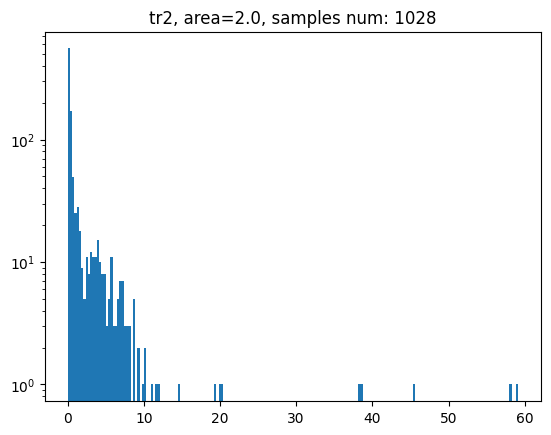

tr2 3.0


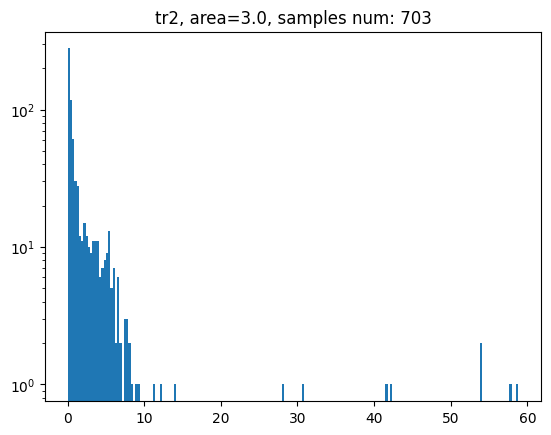

tr2 4.0


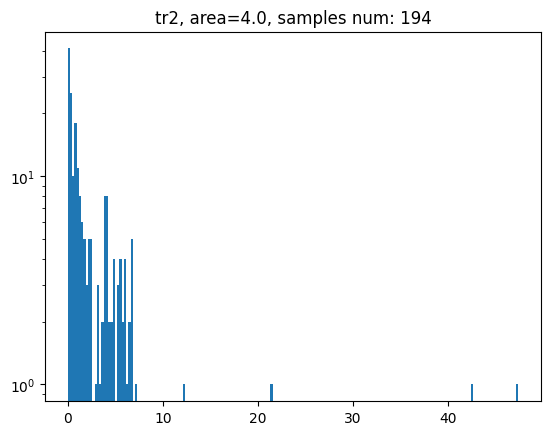

tr2 10.0


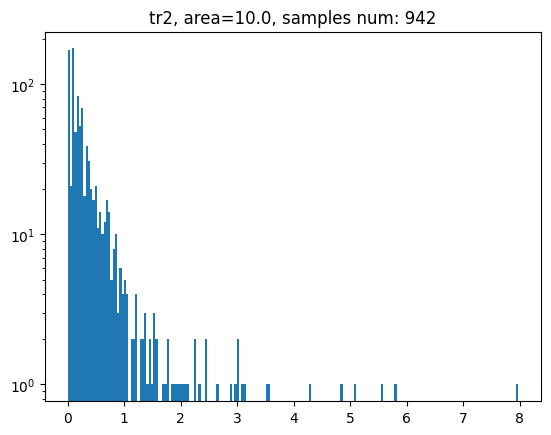

tr2 20.0


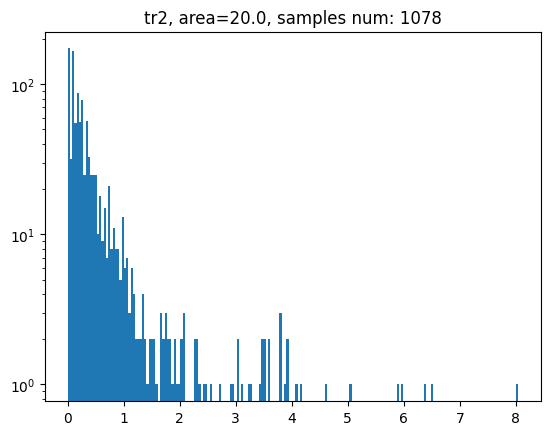

tr2 30.0


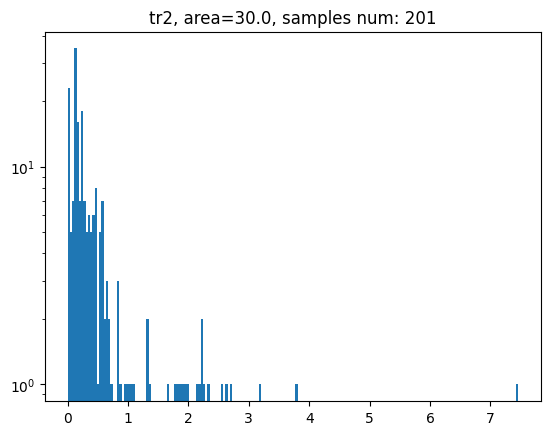

tr2 40


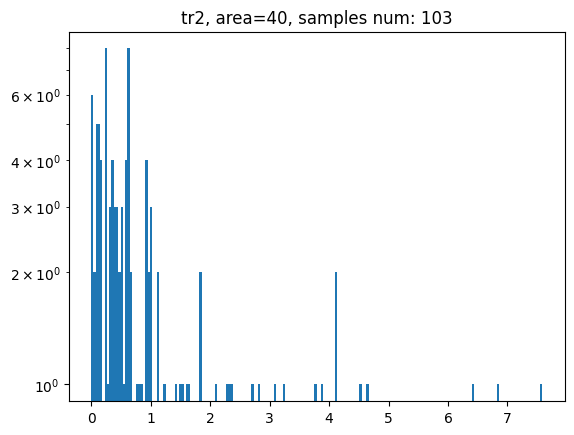

tr3 0.0


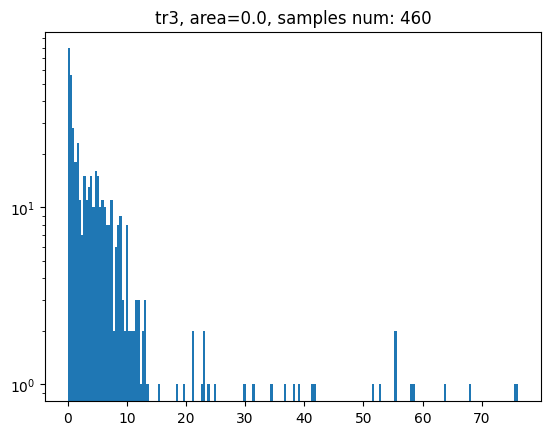

tr3 1.0


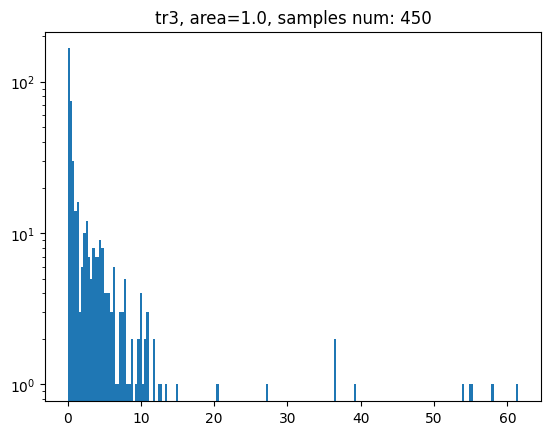

tr3 2.0


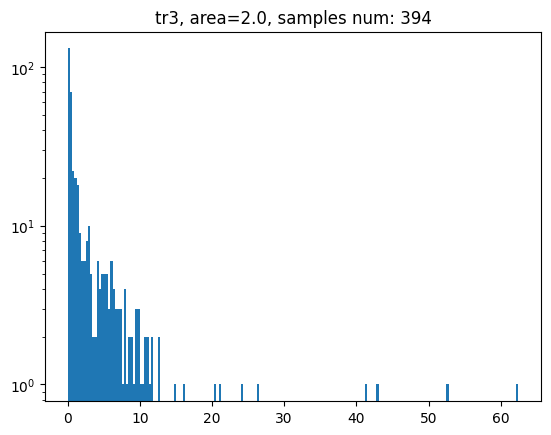

tr3 3.0


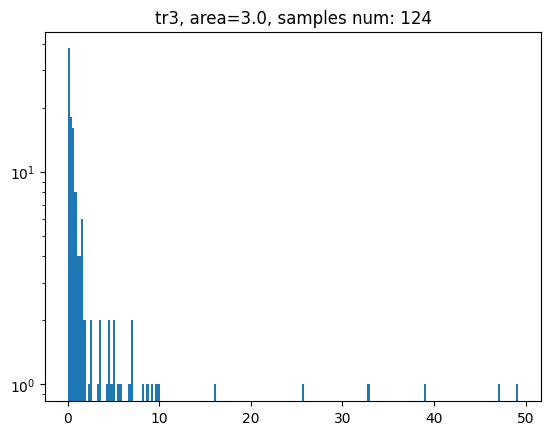

tr3 4.0


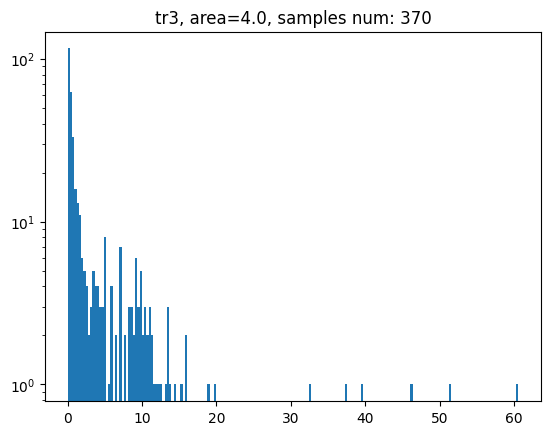

tr3 10.0


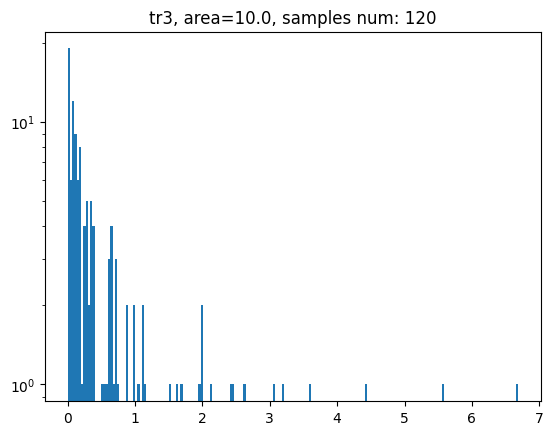

tr3 20.0


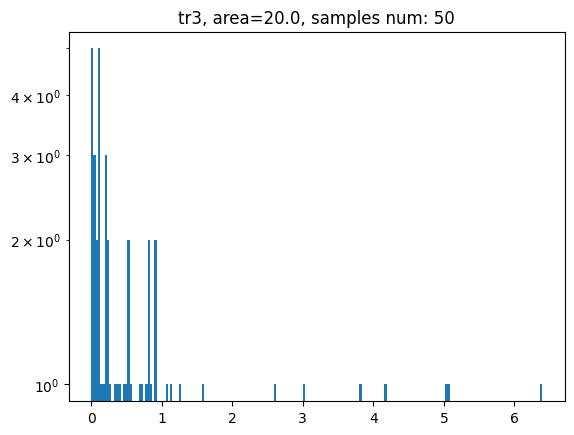

tr3 30.0


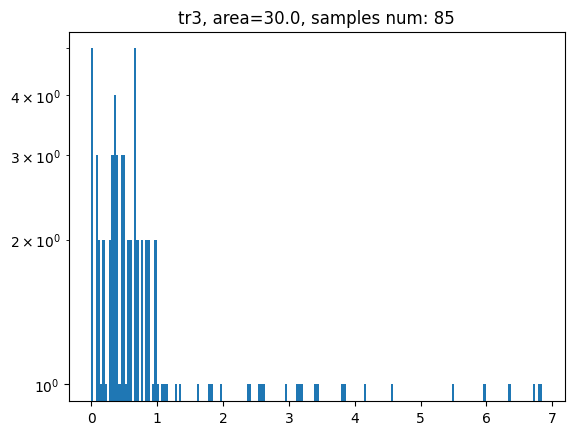

tr3 40


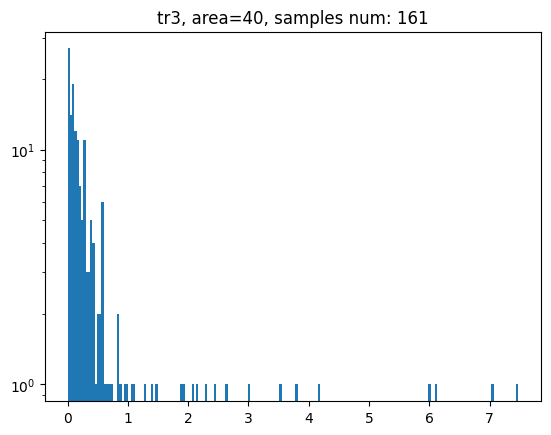

tr4 0.0


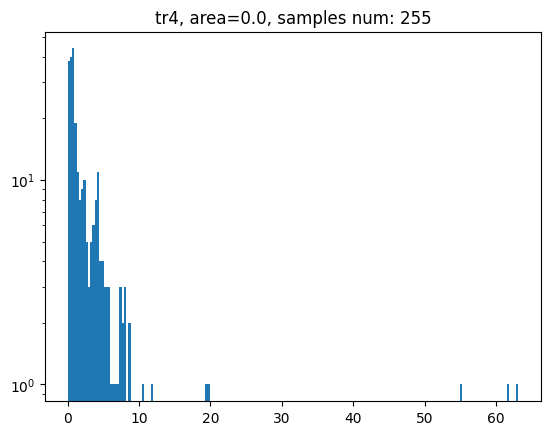

tr4 1.0


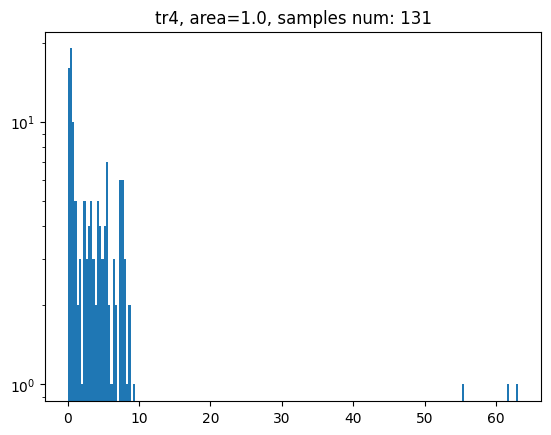

tr4 2.0


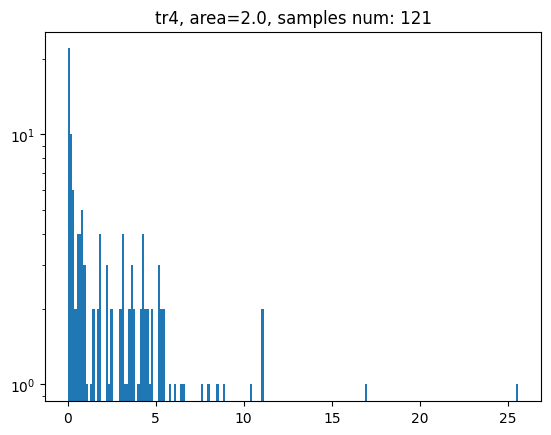

tr4 3.0


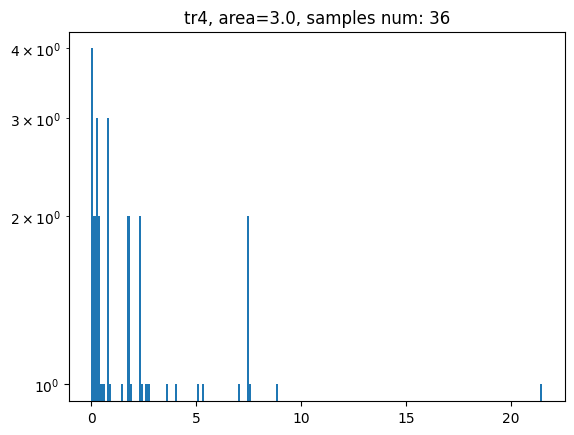

tr4 4.0


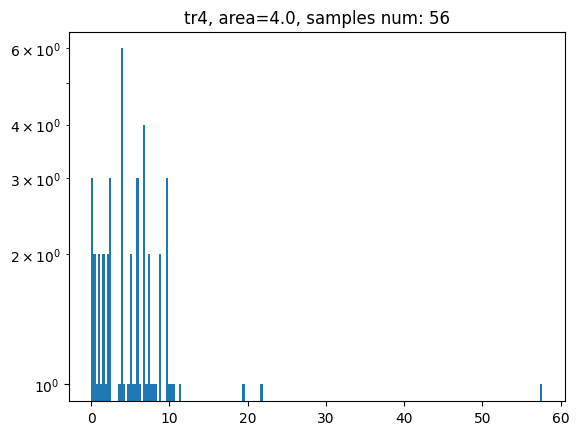

tr4 10.0


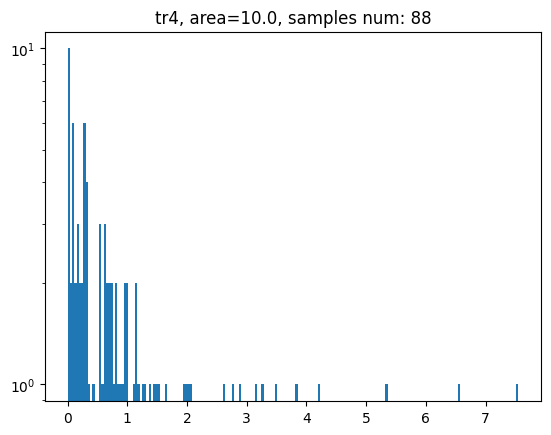

tr4 20.0


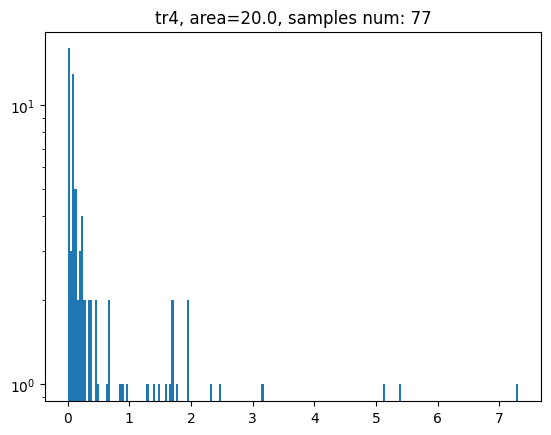

tr4 30.0


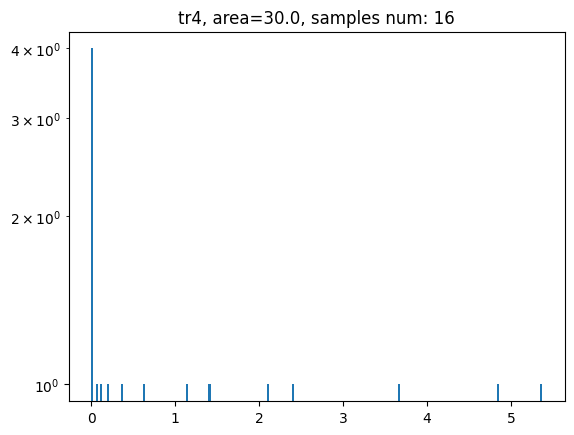

tr4 40


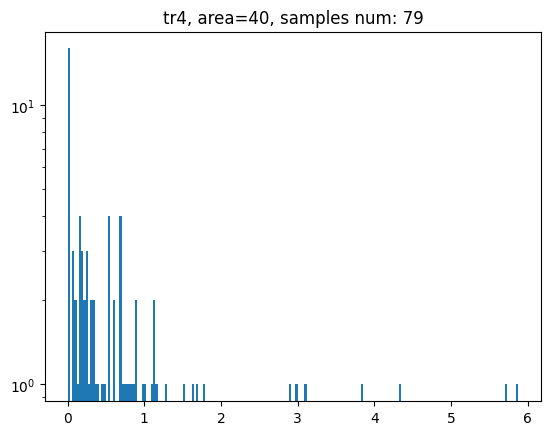

tr5 0.0


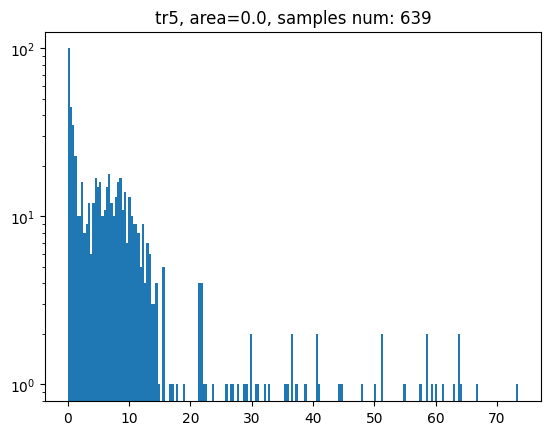

tr5 1.0


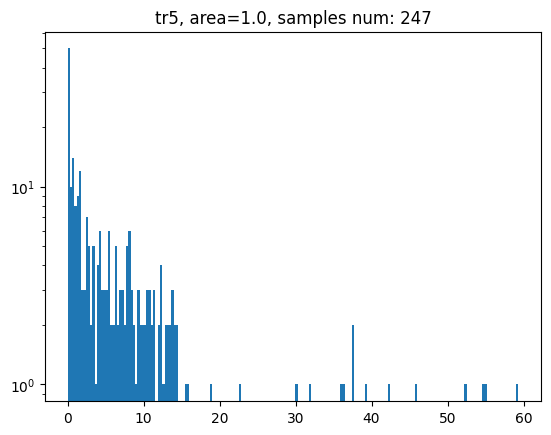

tr5 2.0


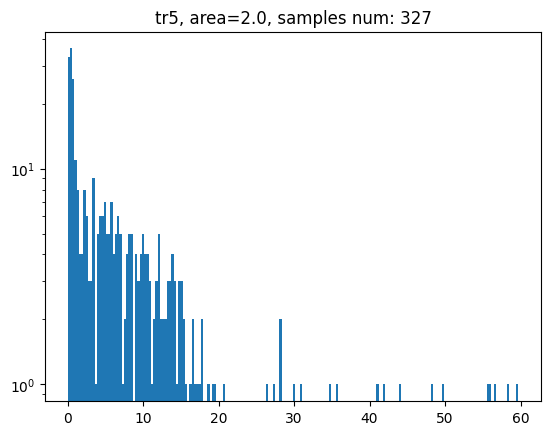

tr5 3.0


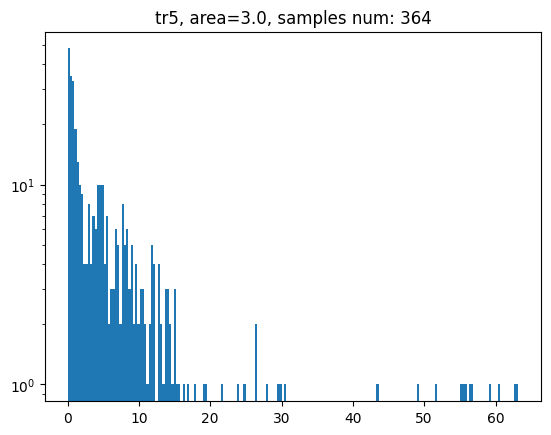

tr5 4.0


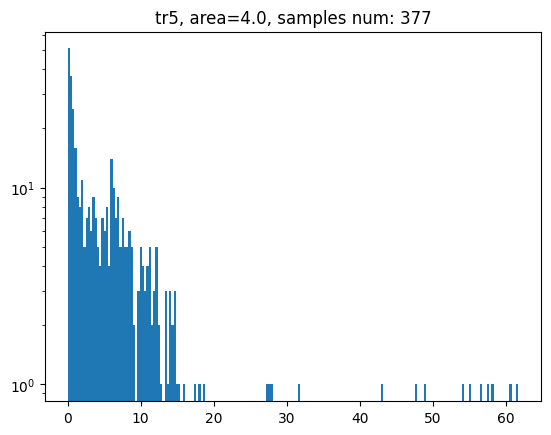

tr5 10.0


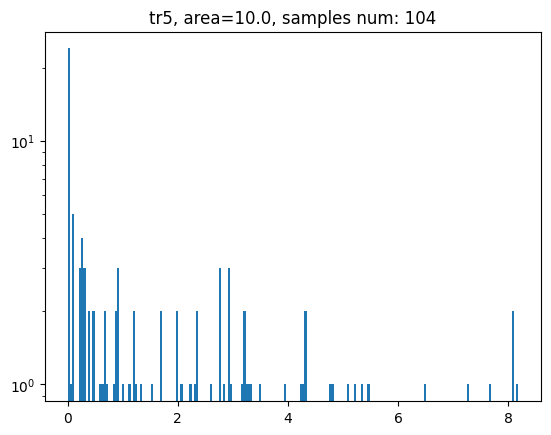

tr5 20.0


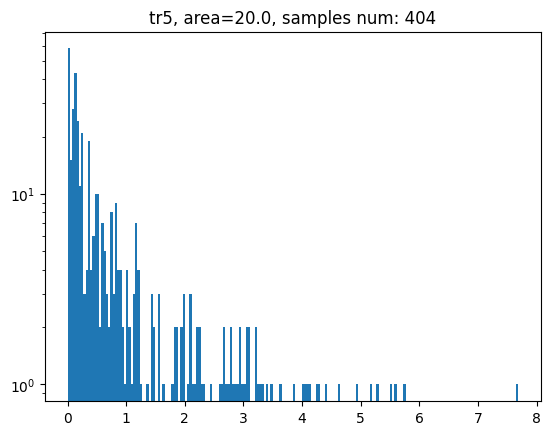

tr5 30.0


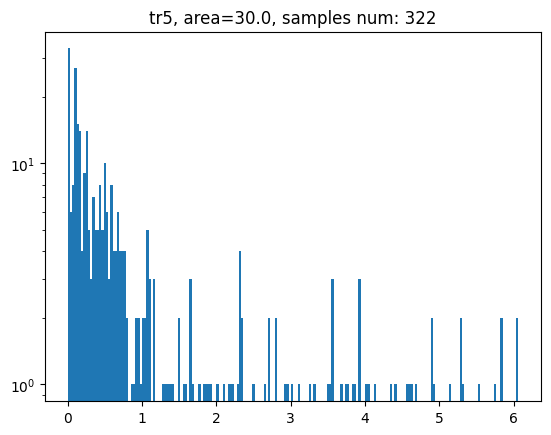

tr5 40


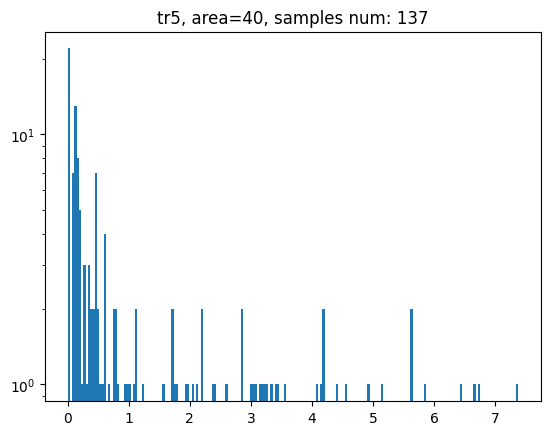

tr6 0.0


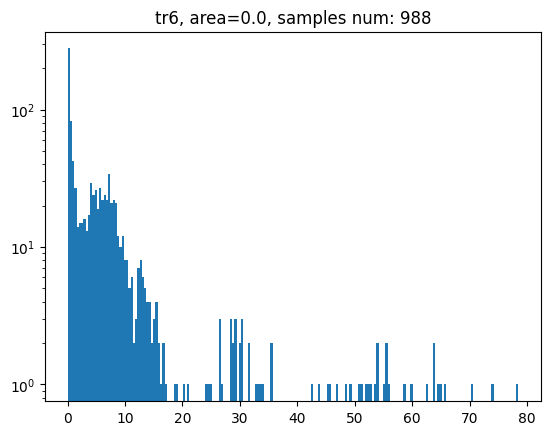

tr6 1.0


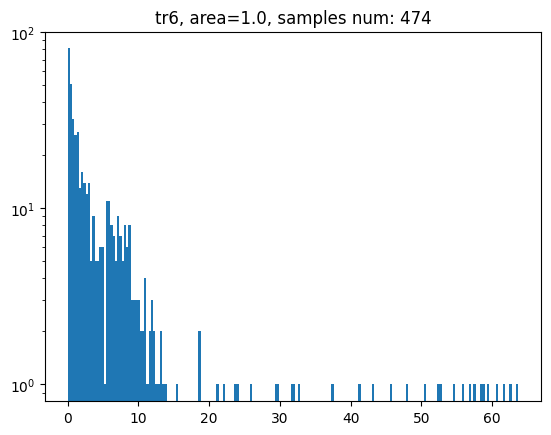

tr6 2.0


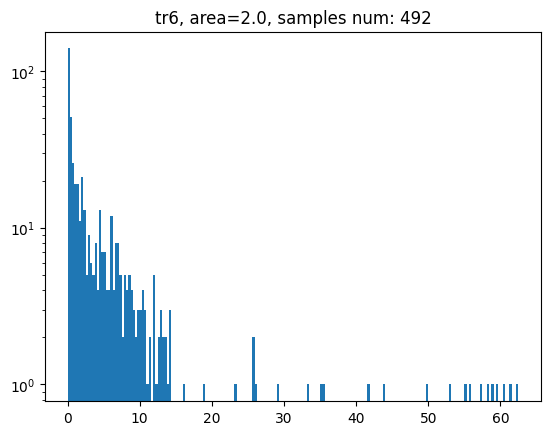

tr6 3.0


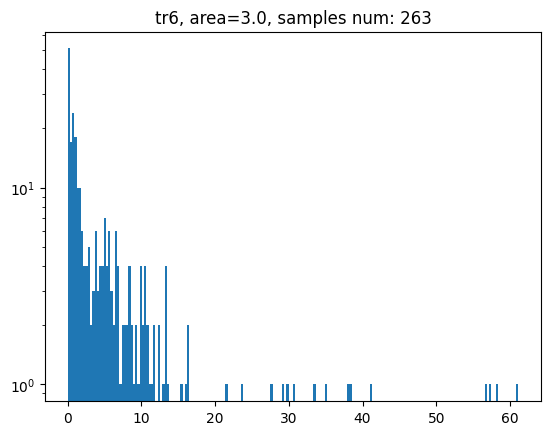

tr6 4.0


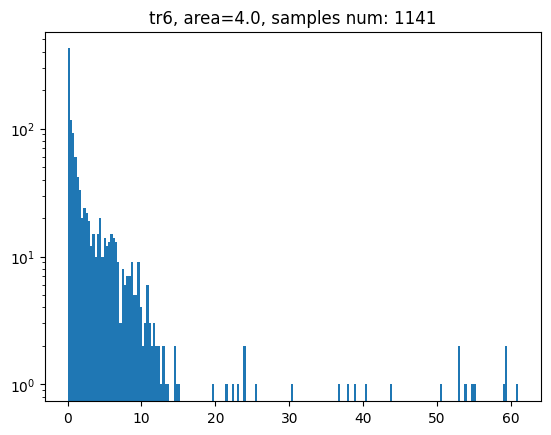

tr6 10.0


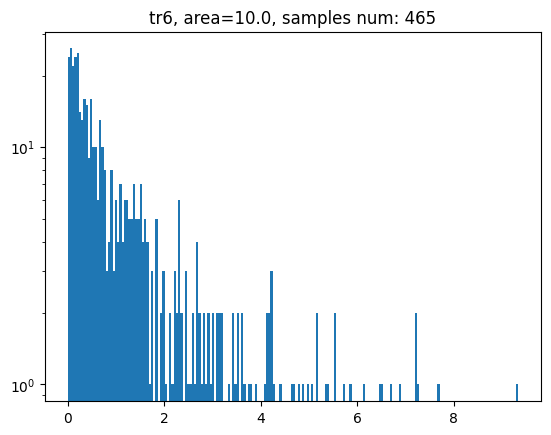

tr6 20.0


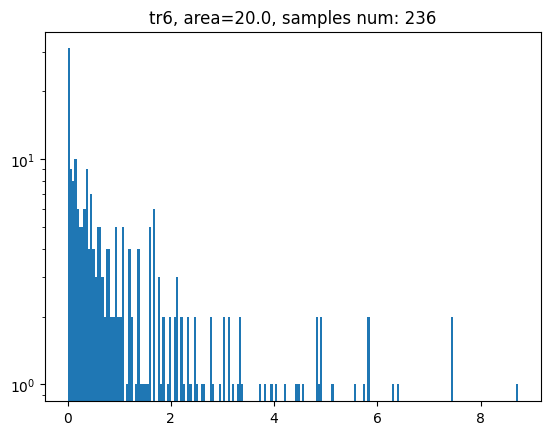

tr6 30.0


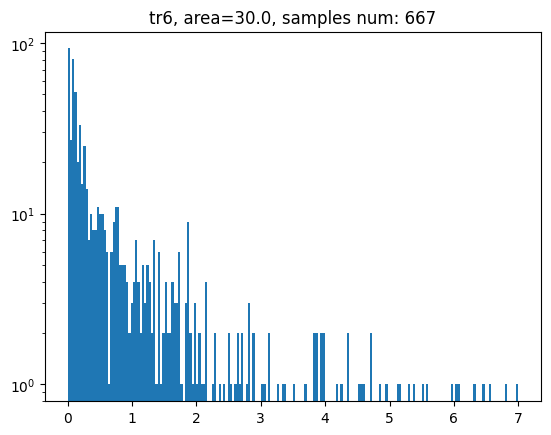

tr6 40


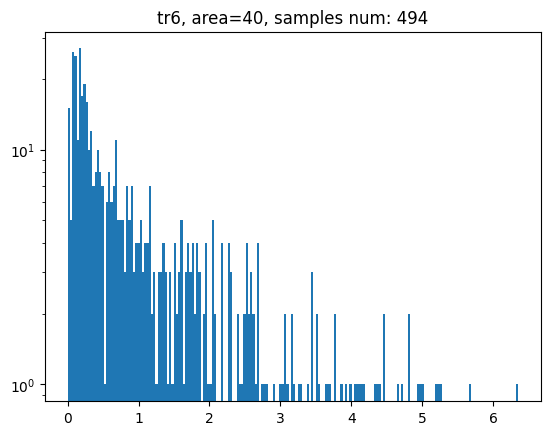

tr7 0.0


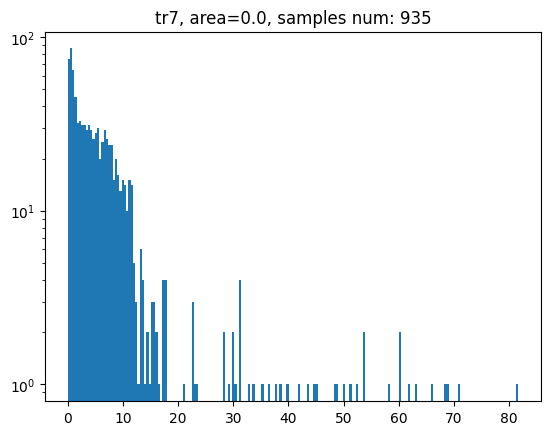

tr7 1.0


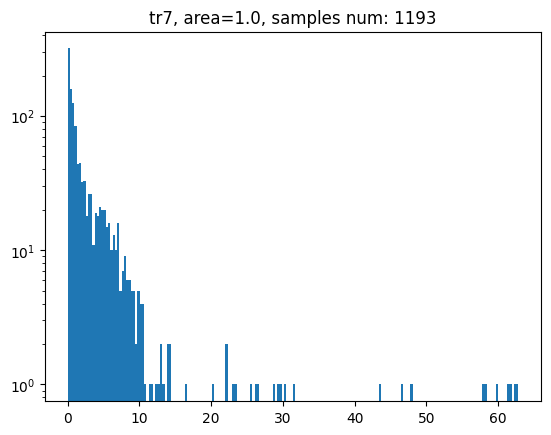

tr7 2.0


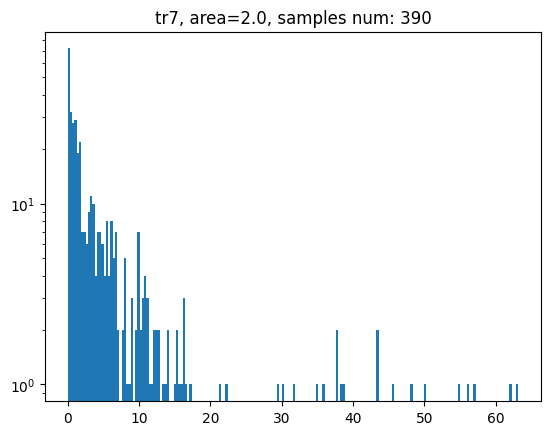

tr7 3.0


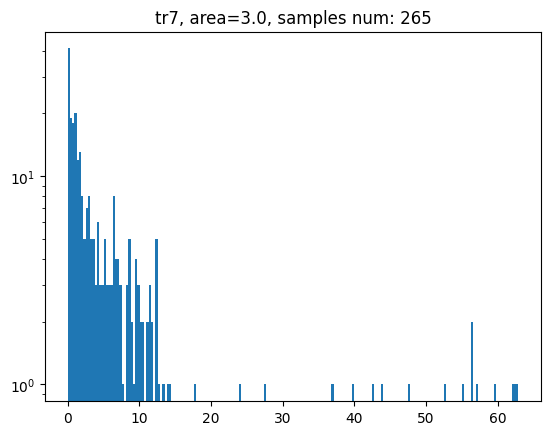

tr7 4.0


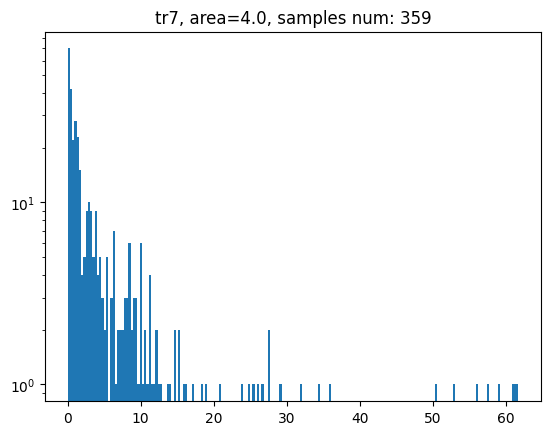

tr7 10.0


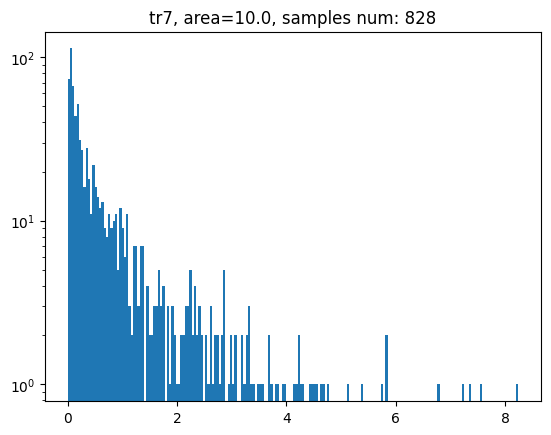

tr7 20.0


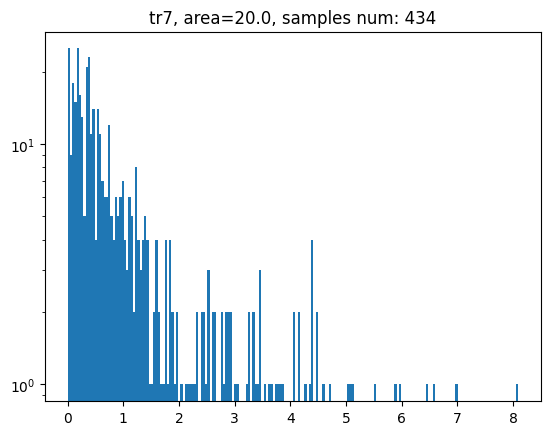

tr7 30.0


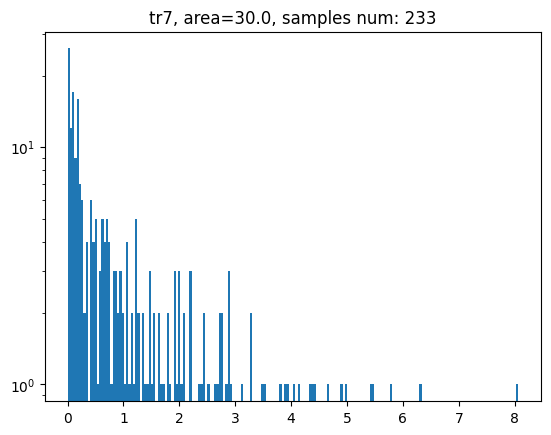

tr7 40


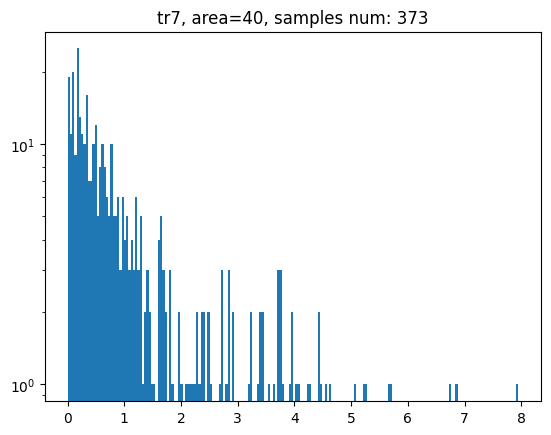

tr91 0.0


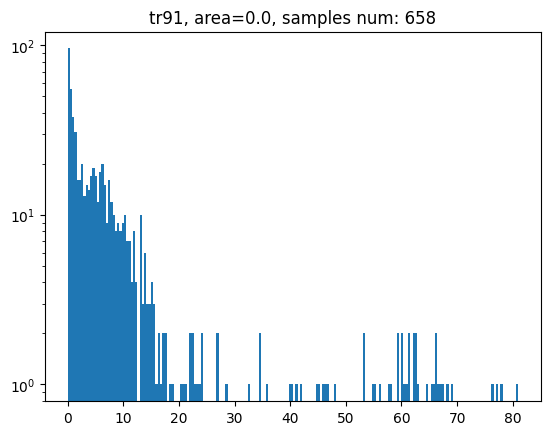

tr91 1.0


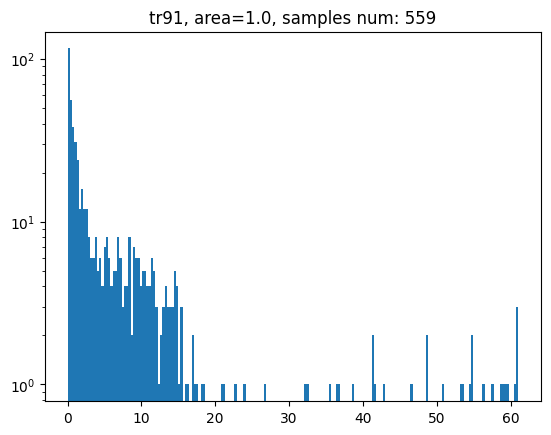

tr91 2.0


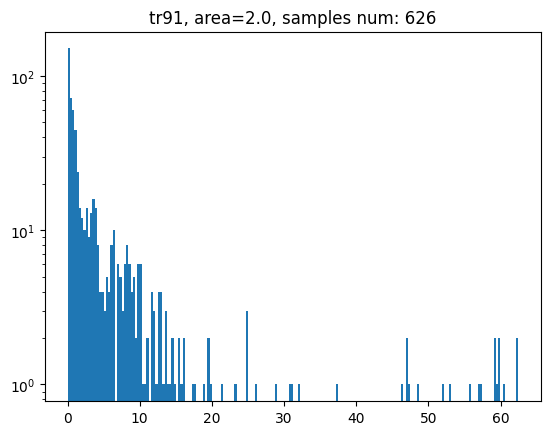

tr91 3.0


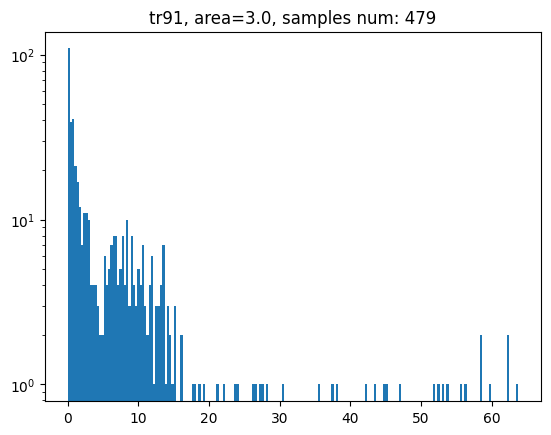

tr91 4.0


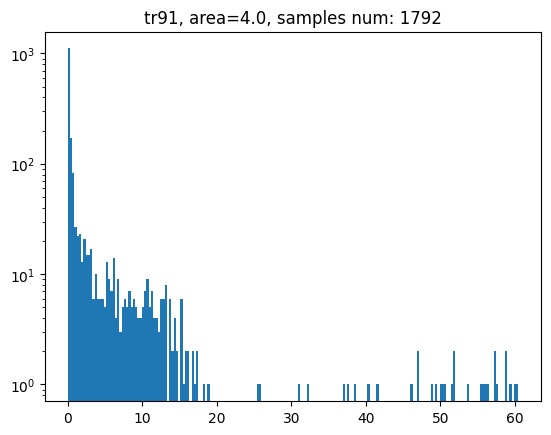

tr91 10.0


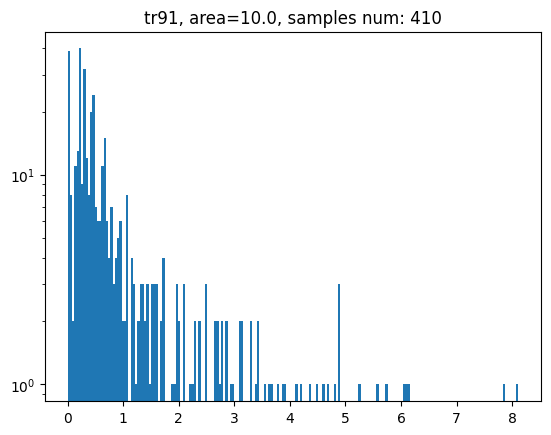

tr91 20.0


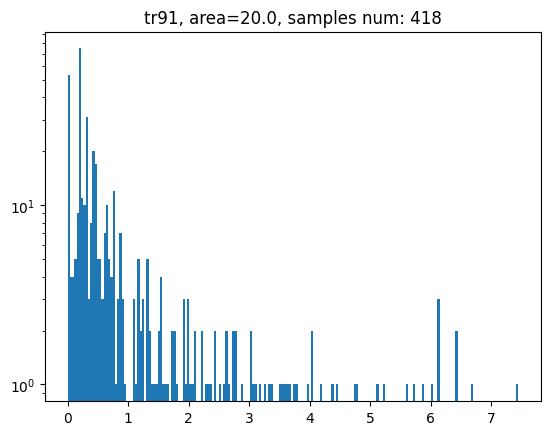

tr91 30.0


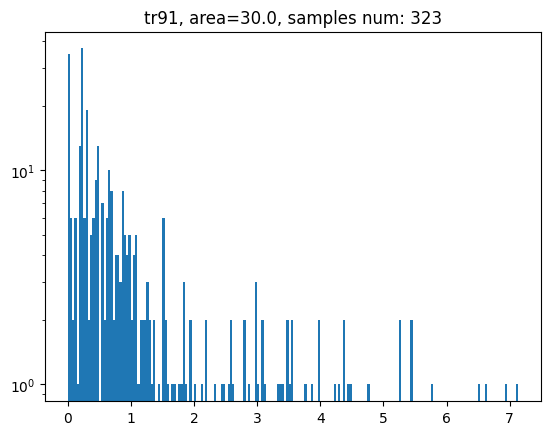

tr91 40


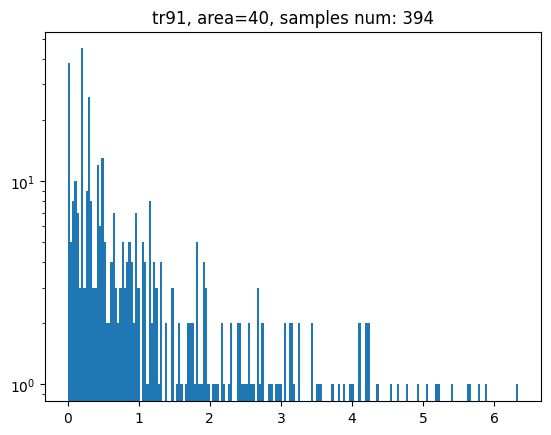

tr92 0.0


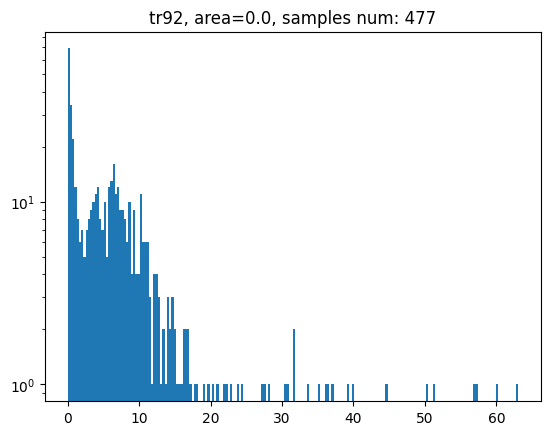

tr92 1.0


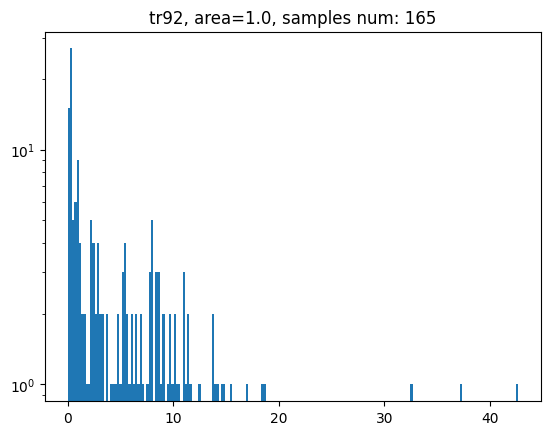

tr92 2.0


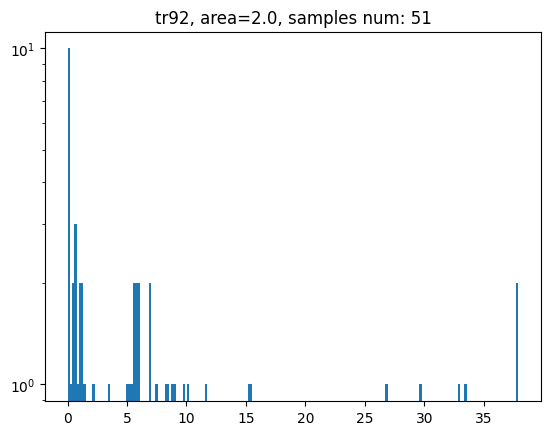

tr92 3.0


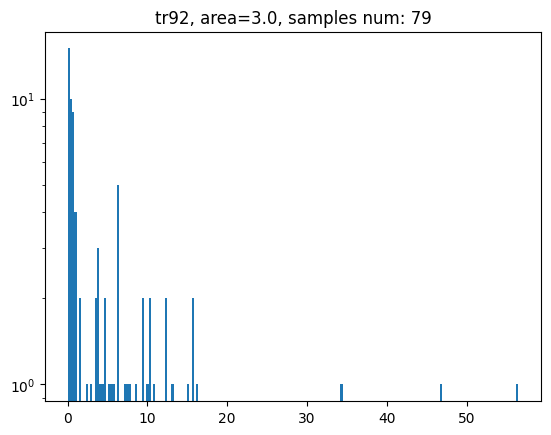

tr92 4.0


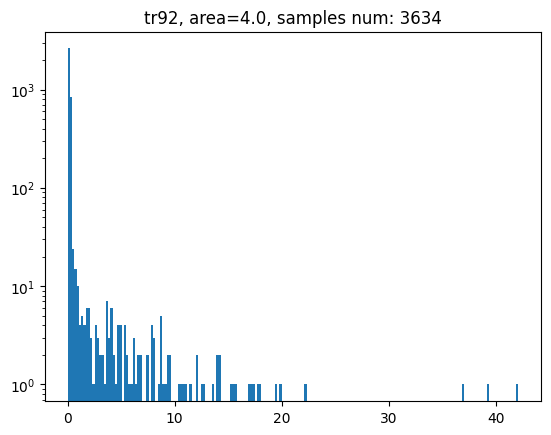

tr92 10.0


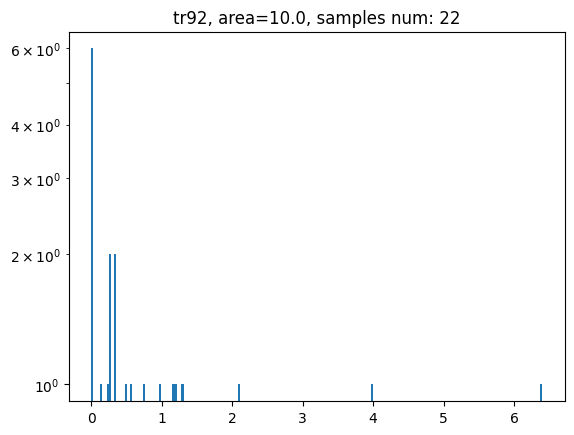

tr92 20.0


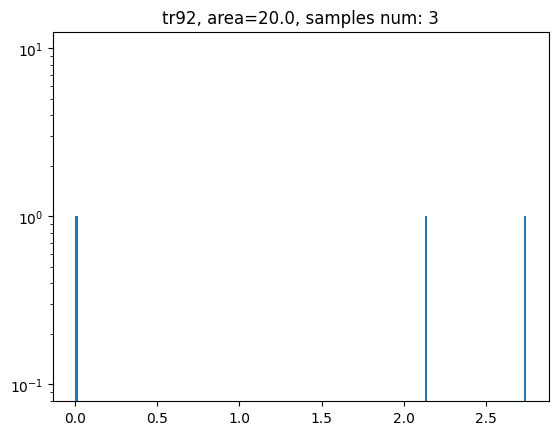

tr92 30.0


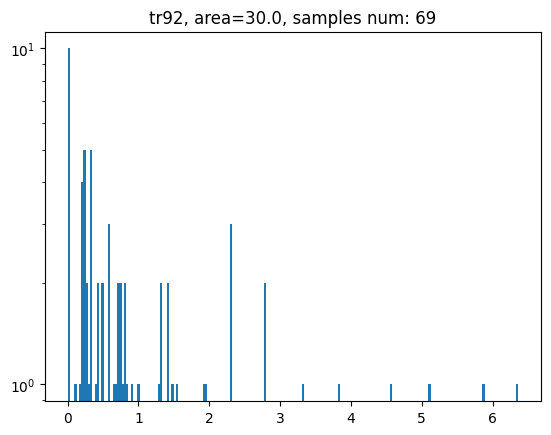

tr92 40


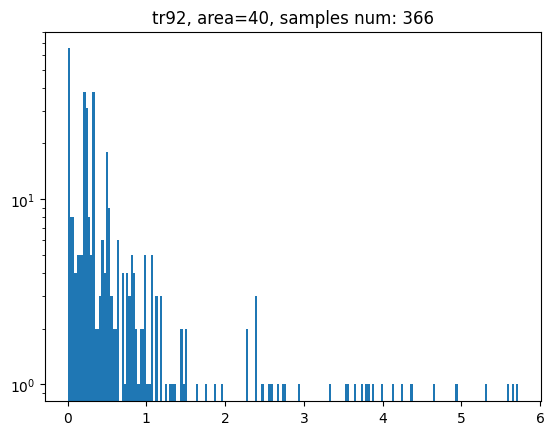

In [131]:
df_steps_hist = {}
for k, df in df_dict.items():

    for area in [0., 1., 2., 3., 4., 10., 20., 30., 40]:
        print(k, area)
        df_in_area = df.loc[df['near_wall']==area].copy()
        h = build_log_hist(df_in_area, binn=200, hist_title=f'{k}, area={area}')
        df_steps_hist[k] = h
        # break
    # break
    # TODO: what is the name of x-axis ??? len of area len units ???
    # TODO: threshold for dropping "sitting" column

In [132]:
# kks0 = {}

# for i in range(len(dfs0)):
#     # т е тут построенный гистографммы со всем колонками, но я в итоге убираю первую колонку
#     #kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])
#     kks0[names[i]] = build3ShistLog(dfs0[i], 0.5)
#     kks0[names[i]] = (kks0[names[i]][0][1:],kks0[names[i]][1][1:])

In [53]:
# STOPPED HERE =======================================================================
# ====================================================================================
# ====================================================================================
# ====================================================================================

aas0 = []
bbs0 = []
for i in kks0:
    otv0 = makeRegrNew(kks0[i], i)
    aas0.append(otv0[0])
    bbs0.append(otv0[1])

[37.79918839 -1.2695907 ]
[50.06283956 -0.99115436]
[41.57380851 -0.70003735]
[48.12435407 -0.71258308]
[85.55932865 -0.85826424]
[60.69242737 -0.8515541 ]
[119.16163815  -0.98459548]
[33.88457673 -1.14916302]


In [54]:
print(statistics.mean(aas0))
print(statistics.mean(bbs0))


59.60727018065556
-0.939617791251118


## проведем анализ 0.5 с углы

In [56]:
dfsC = []
for i in dfs:
    df = i.loc[i['near_wall']>=10]
    dfsC.append(df)

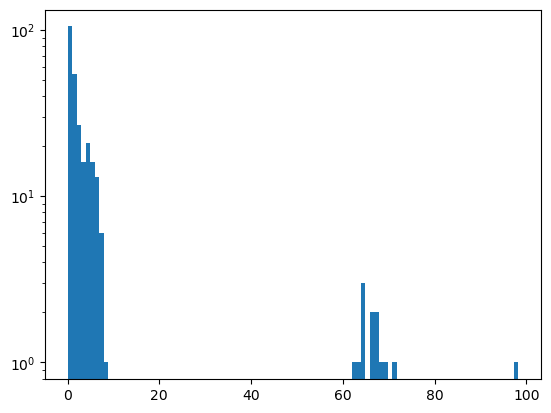

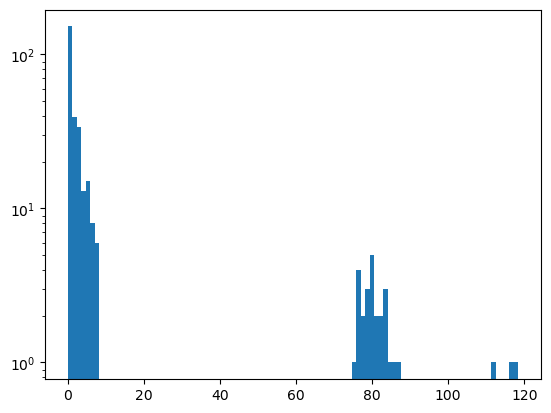

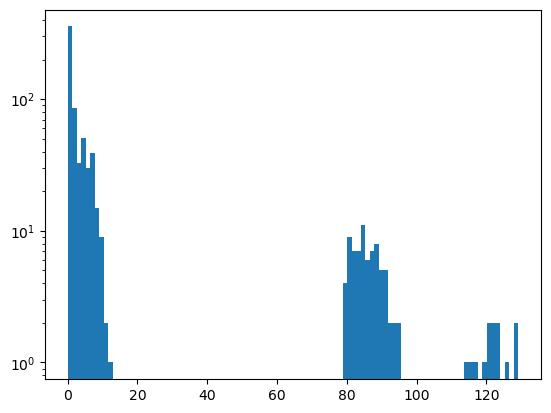

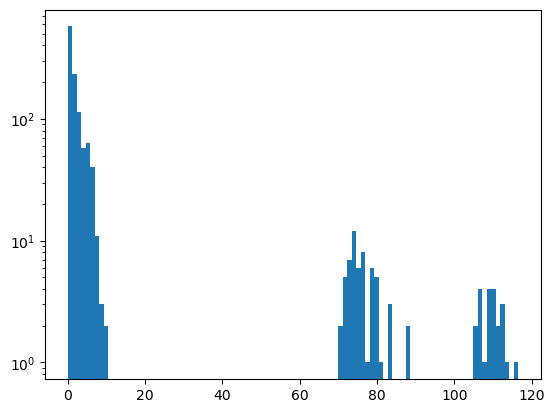

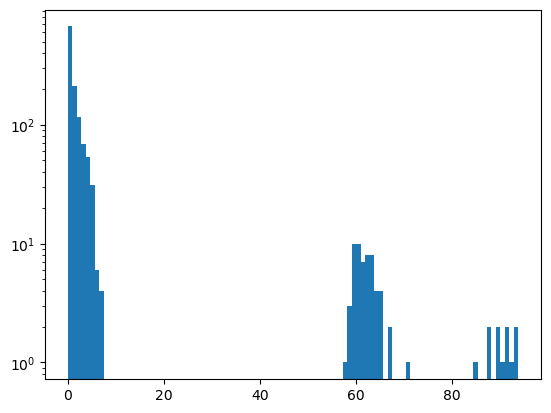

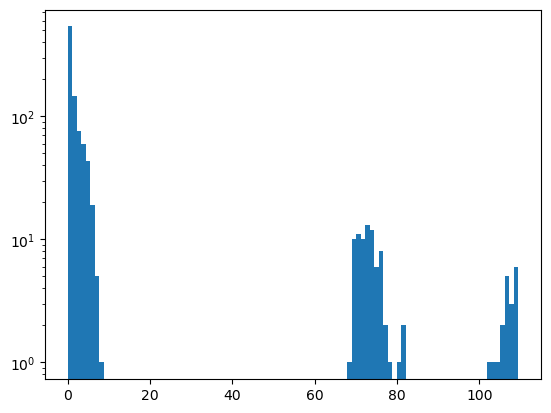

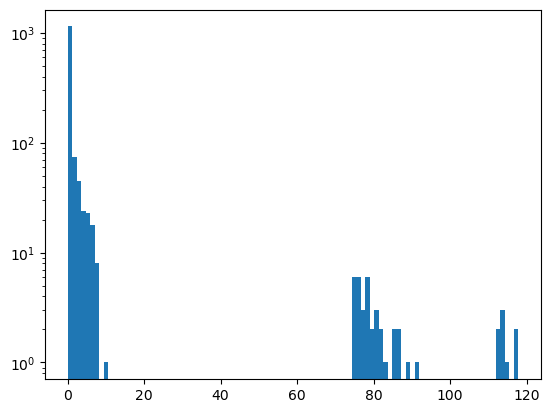

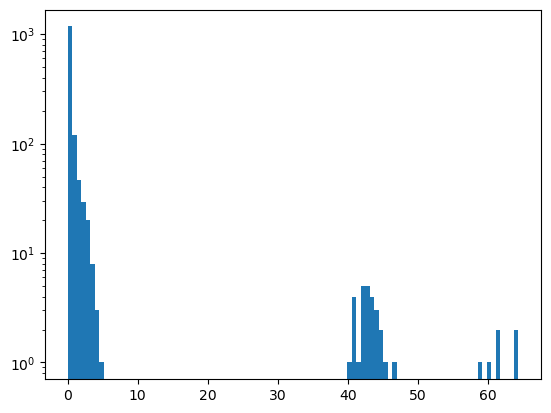

In [57]:
kksC = {}

for i in range(len(dfsC)):
    # т е тут построенный гистографммы со всем колонками, но я в итоге убираю первую колонку
    #kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])
    kksC[names[i]] = build3ShistLog(dfsC[i], 0.5)
    kksC[names[i]] = (kksC[names[i]][0][1:],kksC[names[i]][1][1:])

In [59]:
aasC = []
bbsC = []
for i in kksC:
    otvC = makeRegrNew(kksC[i], i)
    aasC.append(otvC[0])
    bbsC.append(otvC[1])

[163.6124834   -1.61927773]
[176.41625689  -1.61579687]
[351.7214247   -1.47455057]
[1238.70400192   -1.95939793]
[716.50498247  -1.89453085]
[632.0813587   -1.82595015]
[349.28610094  -1.74264186]
[214.2268993   -2.30934651]


In [60]:
print(statistics.mean(aasC))
print(statistics.mean(bbsC))


480.31918853922025
-1.805186557717673


## проведем анализ 0.5 с walls

In [63]:
dfsW = []
for i in dfs:
    df = i.loc[(i['near_wall']>=1) & (i['near_wall']<=4)]
    dfsW.append(df)

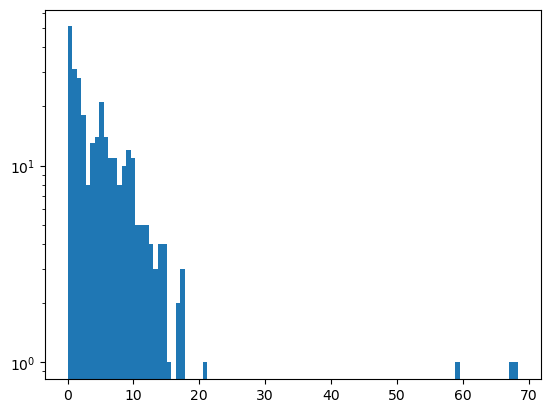

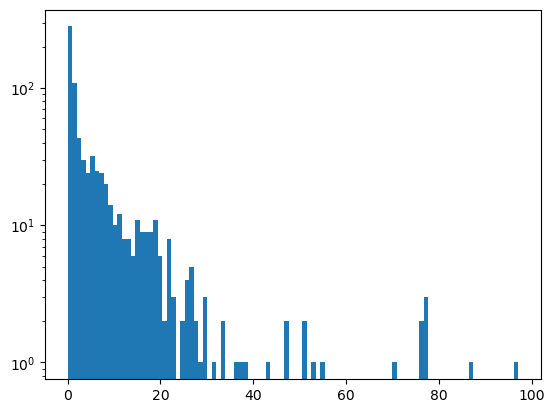

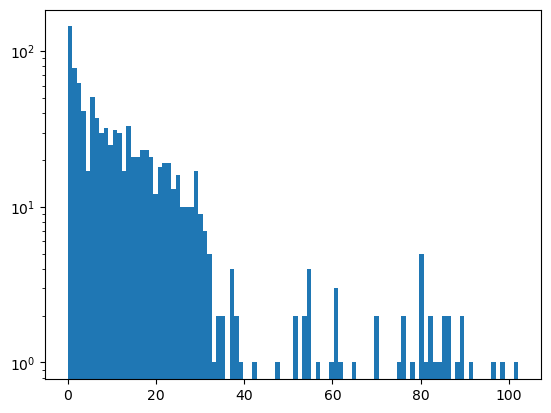

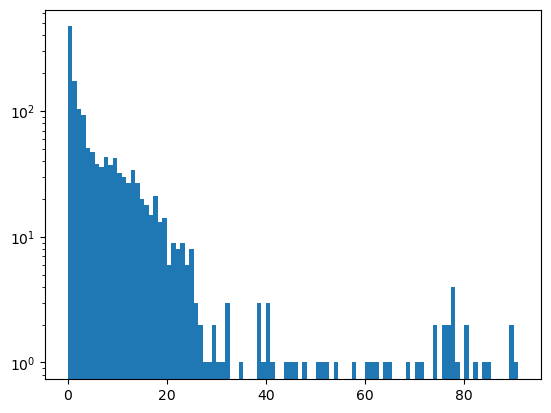

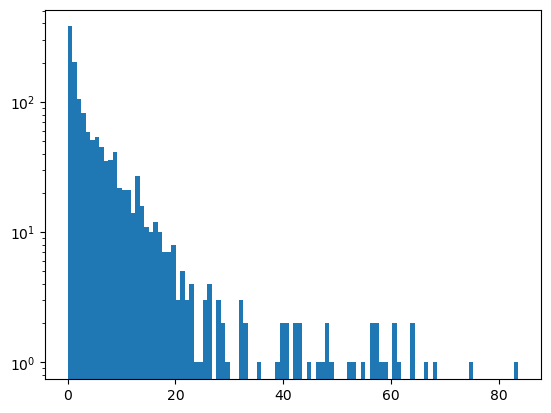

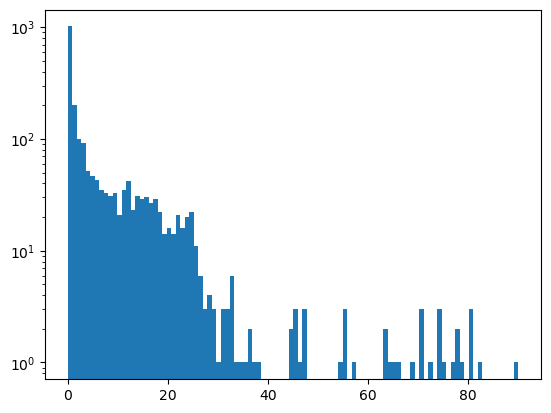

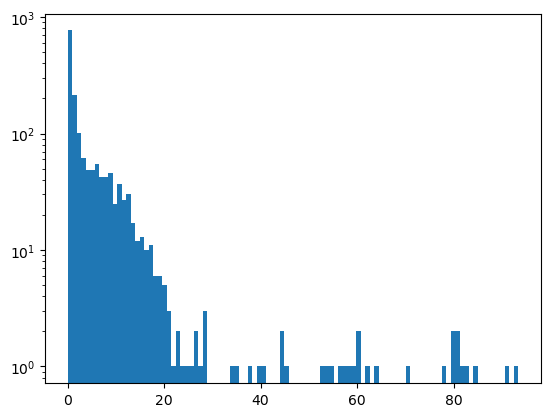

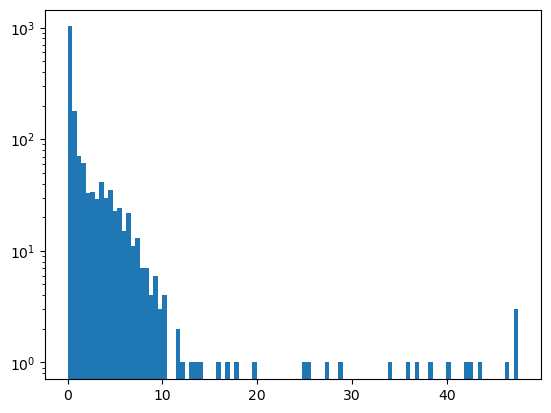

In [64]:
kksW = {}

for i in range(len(dfsW)):
    # т е тут построенный гистографммы со всем колонками, но я в итоге убираю первую колонку
    #kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])
    kksW[names[i]] = build3ShistLog(dfsW[i], 0.5)
    kksW[names[i]] = (kksW[names[i]][0][1:],kksW[names[i]][1][1:])

In [65]:
aasW = []
bbsW = []
for i in kksW:
    otvW = makeRegrNew(kksW[i], i)
    aasW.append(otvW[0])
    bbsW.append(otvW[1])

[49.13930448 -0.9840356 ]
[245.12406558  -1.33969212]
[157.47450116  -0.85934618]
[347.3193598   -1.13745451]
[381.86257336  -1.26276418]
[373.94562427  -1.14415975]
[471.19607175  -1.33952661]
[157.88119629  -1.44396358]


In [66]:
print(statistics.mean(aasW))
print(statistics.mean(bbsW))


272.9928370856509
-1.18886781756936
